In [1]:
%load_ext autoreload
%autoreload 2

# Implementing and automating Ultra Chinese Checkers

[According to Wikipedia](https://en.wikipedia.org/wiki/Chinese_checkers#Fast-paced_or_Super_Chinese_Checkers), the "fast-paced" version of chinese checkers allows one to jump over non-adjacent pieces and is called Super Chinese Checkers. It also mentions a version where one may jump over any symmetrical arrangement of pieces - this is the version I prefer to play, and it seems only natural to name it Ultra Chinese Checkers.

In this notebook, the game is represented and agents are developed which play the game reasonably well.

## Imports

It's just code that somebody else wrote, who needs it

In [2]:
from collections import defaultdict
from enum import Enum
import heapq
import random
from itertools import product

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import numpy as np
import scipy.stats

import plotlib
import plots

mpl.style.use("default")

### Unit vectors for the hexagonal grid

[Redblob's excellent writeup on hexagonal grids](https://www.redblobgames.com/grids/hexagons/) shows why it is natural to index a 2D hexagonal grid with 3 unit vectors in 3-dimensional space, which are then projected onto the grid through some transformation $A$ which maps a 3D vector $\vec{b}$ to a 2D vector $\vec{x}$. We can choose any 3 vectors, I have choosen the unit vectors $\hat{u}$, $\hat{v}$ and $\hat{w}$ such that their projections $A\hat{u}$, $A\hat{v}$ and $A\hat{w}$ fall onto $[1,0]$, $[-1/2, \sqrt{3}/2]$ and $[1/2, \sqrt{3}/2]$ respectively as shown in the plot below.

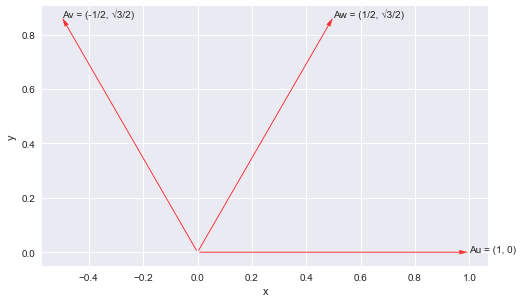

In [3]:
plots.unit_coords_plot()

We see from the plot above that

\begin{align}
A\hat{u}
&=
A
\begin{bmatrix}
1 \\
0 \\
0
\end{bmatrix}
=
\begin{bmatrix}
1 \\
0
\end{bmatrix}
\\
A\hat{v}
&=
A
\begin{bmatrix}
0 \\
1 \\
0
\end{bmatrix}
=
\begin{bmatrix}
-1/2 \\
\sqrt 3/2
\end{bmatrix}
\\
A\hat{w}
&=
A
\begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
+1/2 \\
\sqrt 3/2
\end{bmatrix}
\end{align}

so

\begin{equation}
A
=
\begin{bmatrix}
\hat{u} & \hat{v} & \hat{w}
\end{bmatrix}
=
\begin{bmatrix}
1 & -1/2 & +1/2 \\
0 & \sqrt 3/2 & \sqrt 3/2 \\
\end{bmatrix}
\end{equation}

The `CoordinateTransformer` class wraps a (generic) matrix transformation, and can be used to shift between coordinate systems in this manner. We define the transformer `hex_to_rect` which wraps the transformation $A$ above. The plot below shows how the cartesian unit vectors $\hat{x}$ and $\hat{y}$ relate to $\hat{u}$, $\hat{v}$ and $\hat{w}$, and also the constraint $\hat{w}=\hat{u}+\hat{v}$ that arises from choosing this particular set of hexagonal unit vectors.

In [4]:
# %load coordinate_transformer.py
import numpy as np

class CoordinateTransformer(object):
    def __init__(self, transform):
        self.transform_ = transform
    
    def transform(self, in_vectors, exp=1):
        if len(in_vectors) == 0:
            return np.array(in_vectors)
        if exp != 1:
            return in_vectors @ np.linalg.matrix_power(self.transform_, exp)
        return in_vectors @ self.transform_
    
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

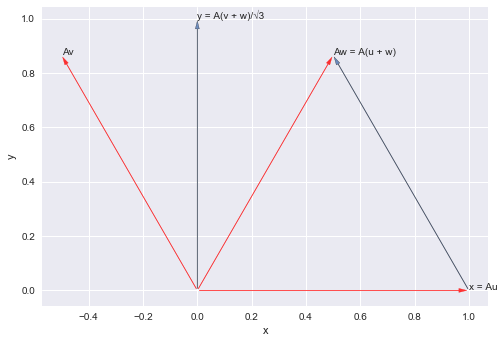

In [5]:
hex_to_rect = CoordinateTransformer([
    [     1,            0 ],
    [  -1/2, np.sqrt(3)/2 ],
    [   1/2, np.sqrt(3)/2 ],
])
plots.coordinate_plot(hex_to_rect)

## Enumerating coordinates close to the origin on the hexagonal grid

The first step towards creating the chinese checkers board is to enumerate all of the coordinates in a hexagon that encloses the board. I came up with 3 ways to generate a hexagon with $n$ spots centered on the origin. Finally, there is the algorithm mentioned in https://www.redblobgames.com/grids/hexagons/#range which is probably the simplest fast algorithm you'll get.

### The algorithms

#### Spiral

Walk in a spiral around the origin and add every new vector.

* Start with $B = \{ [0,0,0] \}, \vec{b}_{0}=[1,0,0]$
* For $k$ from $1$ to $n-1$:
  * Set $\vec{b}=\vec{b}_{i-1}+\hat{u}$
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}+\hat{v}$ and add the new $\vec{b}$ to $B$ at each step
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}-\hat{u}$ and add the new $\vec{b}$ to $B$ at each step
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}-\hat{w}$ and add the new $\vec{b}$ to $B$ at each step
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}-\hat{v}$ and add the new $\vec{b}$ to $B$ at each step
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}+\hat{u}$ and add the new $\vec{b}$ to $B$ at each step
  * Repeat $k$ times: set $\vec{b}_{i}=\vec{b}_{i-1}+\hat{u}$ and add the new $\vec{b}$ to $B$ at each step

#### Brute-force

Add $[\alpha, \beta, \gamma]$ to $B$ for every combination of $\alpha$, $\beta$ and $\gamma$ such that

\begin{align}
\alpha + \beta = \gamma \\
-n \leq \alpha \leq n \\
-n \leq \beta \leq n \\
-n \leq \gamma \leq n \\
\end{align}

#### Fast

Found by looking at the output space for the brute force algorithm and thinking about how to recreate the path directly. I think it goes something like this:

* For $i$ from $-n$ to $0$:
  * For $(j,k)$ from $(-n-i,n)$ to $(n,n+i)$:
    * Add $[i, -n-u+j, -n+k]$ to $B$
* For $i$ from $1$ to $n$:
  * For $(j,k)$ from $(-n,-n-i+1)$ to $(-n+i-1,n)$:
    * Add $[i, -n+j, -n+i+j]$ to $B$

#### Redblob

This produces the same output as the brute-force and fast algorithm, and is more understandable too.

In [6]:
# %load hex_grid_algorithms.py
from itertools import repeat, product

def grid_spiral(n, plot=False):
    x = (0, 0, 0)
    vectors = []
    
    def step(direction, i, add_it=True):
        nonlocal x
        for k in range(i):
            x = tuple(xi + di for xi, di in zip(x, direction))
            if add_it:
                vectors.append(x)
    
    step((0, 0, 0), 1)
    for i in range(1, n+1):
        step(( 1,  0,  0), 1, add_it=False)
        step(( 0,  1,  0), i)
        step((-1,  0,  0), i)
        step(( 0,  0, -1), i)
        step(( 0, -1,  0), i)
        step(( 1,  0,  0), i)
        step(( 0,  0,  1), i)
            
    return vectors

def grid_brute_force(n):
    line = tuple(range(-n, n+1))
    return list(vec for vec in product(line, line, line) if vec[0]+vec[1]==vec[2])

def grid_fast(n):
    return [
        vec for u in range(-n, 0) for vec in zip(repeat(u, 2 * n + 1), range(-n - u, n + 1), range(-n, n + u + 1))
    ] + [
        vec for u in range(n + 1) for vec in zip(repeat(u, 2 * n + 1), range(-n, n - u + 1), range(-n + u, n + 1))
    ]

def grid_redblob(n):
    return [(u, v, u + v) for u in range(-n, n+1) for v in range(max(-n, -u - n), min(n, -u + n) + 1)]

### Spiral vs. the other algorithms

The "Spiral" algorithm mentioned below produces a set of vectors which is different from the other three: the spiral algorithm enumerates every vectors corresponding to all vectors on three of the six faces on a cube, while the others enumerate vectors on a plane going diagonally through that cube. As a result, the grid produced by the spiral algorithm is a little bit smaller than the one produced by the others for the same $n$. It is also rotated by 90 degrees relative to the others.

Here is what the output of the spiral algorithm looks like in hex-space (3 coordinates) and in the projected space (2 coordinates):

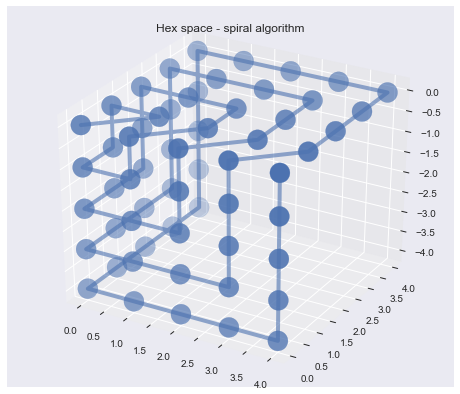

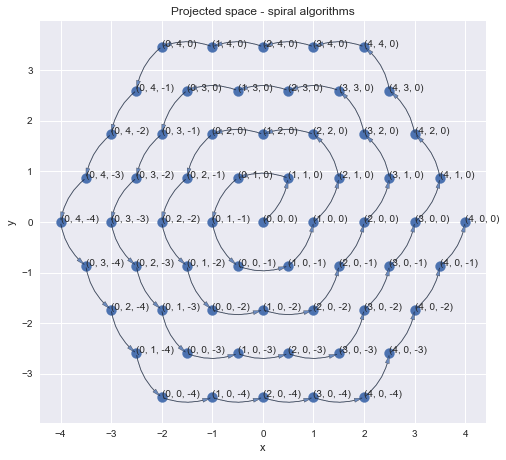

In [7]:
plt.figure(figsize=(8,7))
vectors = grid_spiral(4)
plotlib.plot_vectors(vectors, plt.axes(projection='3d'), title="Hex space - spiral algorithm")
plotlib.plot_path(vectors, hex_to_rect, title="Projected space - spiral algorithms")

Here is what the output of the other algorithms looks like in hex-space and in the projected space:

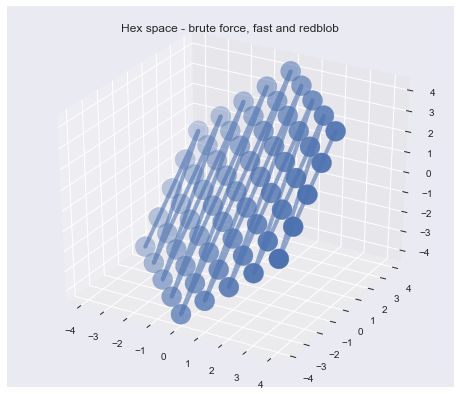

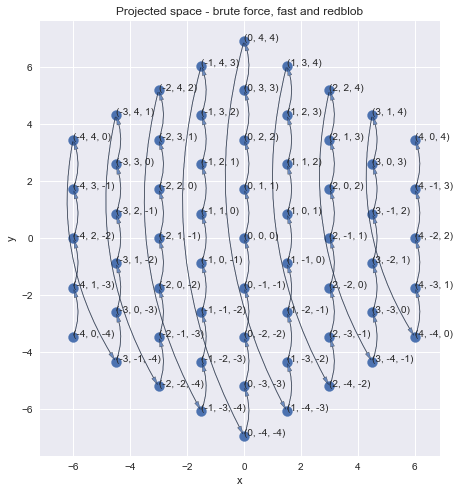

In [8]:
plt.figure(figsize=(8,7))
vectors = grid_fast(4)
plotlib.plot_vectors(vectors, plt.axes(projection='3d'), title="Hex space - brute force, fast and redblob")
plotlib.plot_path(vectors, hex_to_rect, title="Projected space - brute force, fast and redblob")

And here they are together:

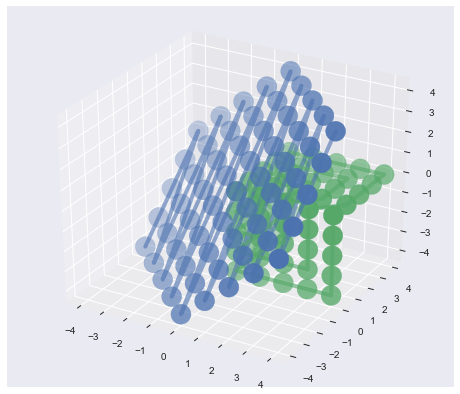

<Figure size 576x396 with 0 Axes>

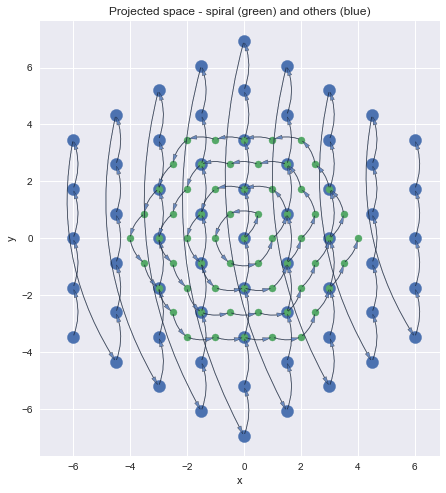

In [9]:
plt.figure(figsize=(8,7))
ax = plt.axes(projection='3d')
plotlib.plot_vectors(grid_fast(4), ax=ax, figure=False, show=False)
plotlib.plot_vectors(grid_spiral(4), ax=ax)
plt.show()

plotlib.plot_path(grid_fast(4), hex_to_rect, text=False, show=False, s=150)
plotlib.plot_path(grid_spiral(4), hex_to_rect, title="Projected space - spiral (green) and others (blue)", text=False, figure=False, s=50,)

### How fast are they?

Any of these algorithms are fine for the tiny $n$ that are relevant here, the time taken to calculate the coordinates is negligible. Nevertheless, when you have many ways to do a thing, it's always fun to see how they perform for larger and larger inputs. If $c$ is the number of coordinates calculated (so $c$ scales with $n^2$), it seems like the brute force solution scales with $c^{3/2}$, the fast and Redblob algorithms scale with $c$, and the spiral algorithm is somewhere inbetween.

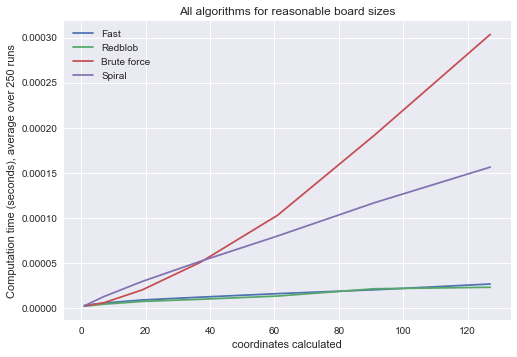

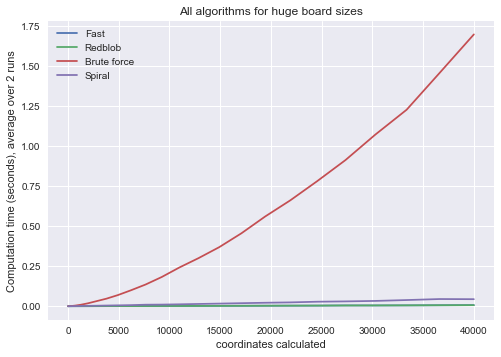

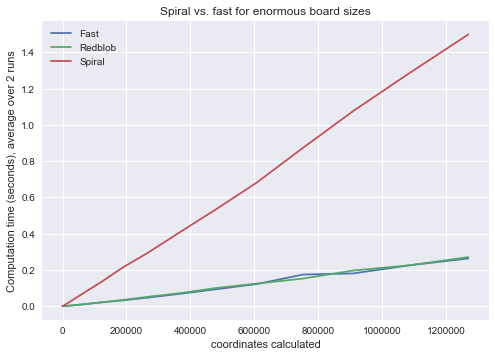

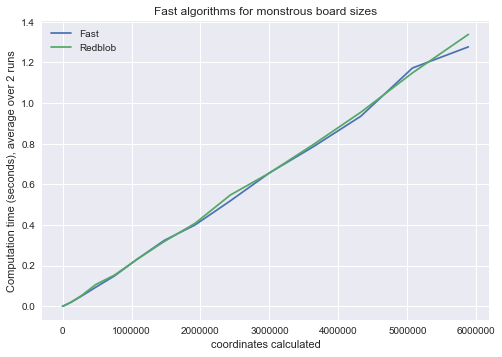

In [10]:
kwargs = {
    'algos': {
        'Fast': grid_fast,
        'Redblob': grid_redblob,
        'Brute force': grid_brute_force,
        'Spiral': grid_spiral,
    },
    'xlabel': "coordinates calculated",
    'xfunc': lambda n: 3 * n * (n + 1) + 1,
    'averagings': 50,
}

kwargs['title'] = "All algorithms for reasonable board sizes"
kwargs['arg_gen'] =  range(0, 7, 1)
kwargs['averagings'] = 250
plotlib.compare_algorithms(**kwargs)

kwargs['title'] = "All algorithms for huge board sizes"
kwargs['arg_gen'] = range(0, 120, 5)
kwargs['averagings'] = 2
plotlib.compare_algorithms(**kwargs)

kwargs['title'] = "Spiral vs. fast for enormous board sizes"
kwargs['arg_gen'] = range(0, 700, 50)
kwargs['algos'].pop('Brute force')
plotlib.compare_algorithms(**kwargs)

kwargs['title'] = "Fast algorithms for monstrous board sizes"
kwargs['arg_gen'] = range(0, 1500, 100)
kwargs['algos'].pop('Spiral')
plotlib.compare_algorithms(**kwargs)

## Rotations

If we see the board from one player's perspective and we want to see if from the perspective of their neighbour, we rotate the board by 60 degrees. Rotating $\hat{u}$ gives $-\hat{v}$, rotating $\hat{v}$ gives $\hat{w}$, and rotating $\hat{w}$ gives $\hat{u}$. Thus rotation by 90 degrees in hex space is represented by the matrix equation

\begin{equation}
A\vec{b}
=
\begin{bmatrix}
-\hat{v} & \hat{w} & \hat{u}
\end{bmatrix}\cdot\vec{b}
=
\begin{bmatrix}
0 & 0 & +1 \\
-1 & 0 & 0 \\
0 & +1 & 0 \\
\end{bmatrix}
\vec{b}
\end{equation}

The coordinates for the next player over is $A^2\vec{b}$, then $A^3\vec{b}$, etc. Or we could go the other way and use $A^{-1}\vec{b}$, $A^{-2}\vec{b}$, etc.

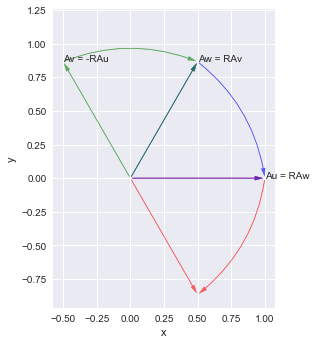

In [11]:
plots.rotation_plot(CoordinateTransformer(np.array([
    [  0, -1,  0],
    [  0,  0, +1],
    [ +1,  0,  0],
])), hex_to_rect)

## Board

The `Board` class encodes the geometry of the board without any players/pieces on it. To create a board, we only need to know its $n$ and the board colors. The defaults are set to some sensible values.

From $n$ and the colors, the Board knows:
* which coordinates are inside of the board
* which coordinates are inside of the central field
* which coordinates belongs to which color

I also add a notion of progress here, which is maybe not so pretty. More on that later.

Some code is needed for plotting the board. A `BoardPlotter` needs to know the `Board` and the transformation used to go from hex coordinates to rectangular ones.

In [12]:
# %load board.py
class Board():
    def __init__(self, n=4, colors = ("red", "yellow", "green", "black", "blue", "grey")):
        self.n = n
        
        # A transformation that rotates the board by 60 degrees.
        rotator = CoordinateTransformer(
            transform = np.array([
                [0, -1, 0],
                [0, 0,  1],
                [1, 0,  0]
            ])
        )
        
        # A function that determines whether the coordinate belongs to the home of color 0.
        # Inferred from looking at the coordinates on the board.
        in_first_home = lambda vec: vec[0] > n and vec[1] >= -n and vec[2] <= n

        # Mapping from color to a function that determines whether the coordinate belongs to its home.
        self.colors = {
            colors[0]: in_first_home,
            colors[1]: lambda vec: in_first_home(rotator.transform(vec, +1)),
            colors[2]: lambda vec: in_first_home(rotator.transform(vec, +2)),
            colors[3]: lambda vec: in_first_home(rotator.transform(vec, +3)),
            colors[4]: lambda vec: in_first_home(rotator.transform(vec, -2)),
            colors[5]: lambda vec: in_first_home(rotator.transform(vec, -1)),
        }
    
        # Mapping from color to a function that measures game progress.
        self.progress_function = {
            colors[0]: lambda vec: - vec[0] + vec[1] - vec[2],
            colors[1]: lambda vec: - vec[0] - vec[1] - vec[2],
            colors[2]: lambda vec: + vec[0] - vec[1] - vec[2],
            colors[3]: lambda vec: + vec[0] - vec[1] + vec[2],
            colors[5]: lambda vec: + vec[0] + vec[1] + vec[2],
            colors[4]: lambda vec: - vec[0] - vec[1] + vec[2],
        }

        # Mapping from color to the color of the opposing player.
        self.opposing = {
            colors[0]: colors[3],
            colors[1]: colors[4],
            colors[2]: colors[5],
        }
        for a, b in self.opposing.copy().items():
            self.opposing[b] = a
        
        # All vectors that may possibly be on the board
        hex_vectors = self.hexgrid()
        
        # All vectors in the central field
        self.field_spots = list(map(tuple, filter(self.in_field, hex_vectors)))
        
        # All vectors in each home
        self.color_spots = {
            color: list(map(tuple, filter(func, hex_vectors)))
            for color, func in self.colors.items()
        }
        
        # All vectors in 
        self.board_spots = self.field_spots.copy()
        for spots in self.color_spots.values():
            self.board_spots.extend(spots)
    
    def in_board(self, vec):
        """Returns whether the vector is inside of the board"""
        if self.in_field(vec, self.n):
            return True
        for func in self.colors.values():
            if func(vec, self.n):
                return True
        return False

    def in_field(self, vec):
        """Returns whether the vector is inside of the central field"""
        return (abs(vec[0]) + abs(vec[1]) + abs(vec[2])) <= 2 * self.n
    
    def hexgrid(self):
        """Returns a list of vectors that may or may not be inside of the board."""
        n = self.n * 2
        vectors = []
        for u in range(-n, n+1):
            us = [u] * (2*n+1)
            if u < 0:
                vectors.extend(zip(us, range(-n-u, n+1), range(-n, n+u+1)))
            else:
                vectors.extend(zip(us, range(-n, n-u+1), range(-n+u, n+1)))
        return vectors

class BoardPlotter(object):
    def __init__(self, board, transformer):
        self.board = board
        self.transformer = transformer
    
    def plot_transformed(self, in_vectors, newfig=True, text=False, **kwargs):
        mpl.style.use("default")
        if newfig:
            plt.figure(figsize=(7, 7))
        
        transformed = self.transformer(np.array(in_vectors))
        
        if text:
            for (xh, yh, zh), (x, y) in zip(in_vectors, transformed):
                plt.text(x, y, "[{},{},{}]".format(xh, yh, zh), fontsize=7)
        
        if len(transformed) > 0:
            alpha = kwargs.pop('alpha', 0.3)
            plt.scatter(*transformed.T, alpha=alpha, **kwargs)
        plotlib.geom_plot(xticks=[], yticks=[], xlabel="", ylabel="")
    
    def plot_spots(self, text=False, **kwargs):
        newfig = kwargs.pop('newfig', False)
        self.show_spots(self.board.field_spots, newfig=newfig, color="lightgreen", text=text, **kwargs)
        for color, spots in self.board.color_spots.items():
            self.show_spots(spots, newfig=False, color=color, text=text, **kwargs)
    
    def plot_move(self, vec_in, vec_out, curved=True, **kwargs):
        plotlib.arrow(self.transformer(vec_in), self.transformer(vec_out), curved, **kwargs)
    
    def show_spots(self, spots, **kwargs):
        self.plot_transformed(spots, **kwargs)

Here's what that looks like:

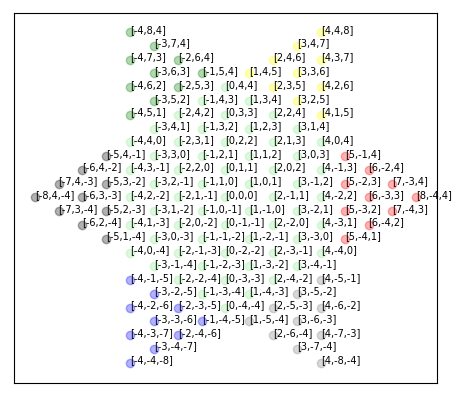

In [13]:
board_plotter = BoardPlotter(Board(), hex_to_rect)
board_plotter.plot_spots(text=True)

### Definition of progress

From the plot above, we can see how the coordinates change e.g. when we move from black to red, from green to grey, etc. Each index $u$, $v$ and $w$ either increases or decreases. Therefore, one possible definition of each player's progress is some sum of the coordinate indices. It could also be a nonlinear function of the indices - for example, it's probably more important to get pieces out of the home than to get them far in the back. In any case, if we know one, we can get the progress for any of the other players by applying the aforementioned rotation matrix to the position before calculating the progress.

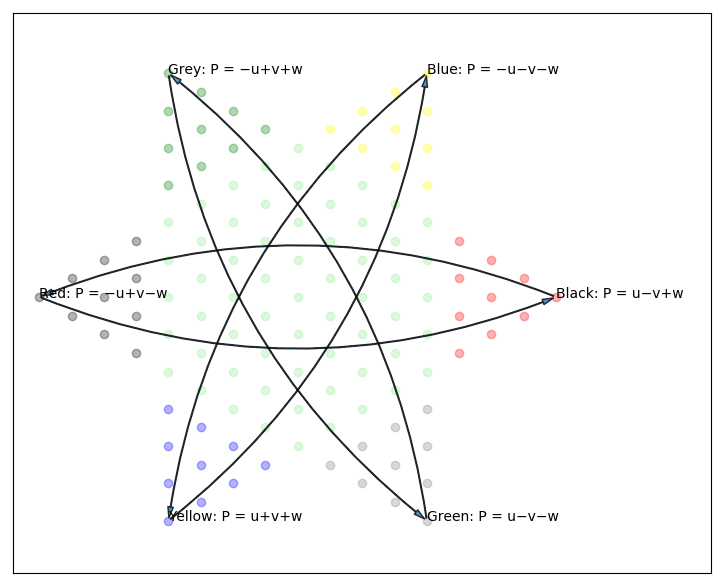

In [14]:
plots.progress_plot(board_plotter)

## Game

`Game` encodes the rules of the game.

Terminology used:

* A `spot` is a location on the board.
* A `move` is a single legal jump.
* A `play` is a sequence of legal moves which ends at a legal spot.

There are a couple of auxillary classes I found useful:
* An `Exception` that gets thrown when an invalid move occurs
* A `MoveState` enum to keep track of the move in a play. What counds as a legal move depends on the previous move in a few simple ways.
* With regards to plotting, the only other thing we need to know is where the players are. The `GamePlotter` uses a `BoardPlotter` and the `Game` to plot what's going on.

Other tricks:

* Checking whether a spot is occupied is done a _lot_, so the result is cached.
* It is often useful to check what happens after making a move without actually doing it. This functionality is added by having a stack of moves. "Pushing" a move performs the move and adds it to the stack. Moves should then be "popped" in reverse order - this performs the reverse move.
* The `run` function can be provided with different "hooks" that will be called during various points of the game. This allows for e.g. plotting or collecting statistics.

In [15]:
# %load game.py
class InvalidMoveException(Exception):
    pass

class MoveState(Enum):
    FIRST = 0
    SUBSEQUENT = 1
    SUBSEQUENT_AFTER_SINGLE_MOVE = 2
    ALREADY_CHECKED = 3

class Game(object):
    TRUST_PLAYERS = False
    
    def __init__(self, players, n=4):
        self.board = Board(n)
        self.players = players
        self.player_spots = {
            color: spots.copy()
            for color, spots in self.board.color_spots.items()
            if color in players
        }
        self.cache_occupied = {}
        self.move_stack = []

    def get_line(self, vec_in, vec_out):
        """Find the line of coordinates from vec_in to vec_out.
        This code is currently the main hot path
        """
        for d, (xi, xo) in enumerate(zip(vec_in, vec_out)):
            # Search for a shared coordinate
            if xi != xo:
                continue

            # Next coordinate is not shared
            d2 = d + 1
            if d2 == 3:
                d2 = 0
                d3 = 1
            elif d2 == 2:
                d3 = 0
            else:
                d3 = d2 + 1
            
            # Find the line from vec_in to vec_out
            line = np.array([spot for spot in self.board.board_spots if spot[d] == xi])

            # Sort it
            line_d2 = line[:, d2]
            line_d2_argsort = np.argsort(line_d2)
            line_d2 = line_d2[line_d2_argsort]
            line = line[line_d2_argsort]
            
            # Tricky
            vec_in_d2 = vec_in[d2]
            vec_out_d2 = vec_out[d2]
            mini_idx = min(vec_in_d2, vec_out_d2)
            maxi_idx = max(vec_in_d2, vec_out_d2)
            mini = np.argmax(line_d2 == mini_idx)
            maxi = np.argmax(line_d2 == maxi_idx)
            start = min(mini, maxi)
            stop = max(mini, maxi) + 1
            return line[start:stop]
    
    def occupied(self, spot):
        """Returns whether the spot is occupied"""
        if spot in self.cache_occupied:
            return self.cache_occupied[spot]
        else:
            for player, spots in self.player_spots.items():
                for spot_ in spots:
                    if spot == spot_:
                        self.cache_occupied[spot] = True
                        return True
        self.cache_occupied[spot] = False
        return False

    def occupation(self, line, vec_in):
        """Returns whether each spot in the line is occupied"""
        return [self.occupied(spot) and spot != vec_in for spot in line]
    
    def is_legal_move(self, player, vec_in, vec_out, move_state=MoveState.FIRST):
        """Returns whether vec_out is a legal place to stay in temporarily"""
        if move_state == MoveState.ALREADY_CHECKED and Game.TRUST_PLAYERS:
            return True, move_state
        
        # Cannot move after having made a single move
        if move_state == MoveState.SUBSEQUENT_AFTER_SINGLE_MOVE:
            return False, move_state
        
        # Cannot stop in an occupied spot
        if self.occupied(vec_out):
            return False, move_state
        
        # Look at the line from vec_in to vec_out
        line = self.get_line(vec_in, vec_out)
        
        # If there is no such line, we cannot stop there
        if line is None or len(line) == 0:
            return False, move_state
        
        # Special rule: 1-step moves need not be symmetric
        if move_state == MoveState.FIRST and len(line) == 2:
            return True, MoveState.SUBSEQUENT_AFTER_SINGLE_MOVE
        
        # Look at whether each spot in the line is occupied
        occupation = self.occupation(map(tuple, line), vec_in)
        
        # Line through position must be symmetric
        no_occupation = True
        len_ = len(occupation)
        for i in range((len_ + 1) // 2):
            occ, rocc = occupation[i], occupation[len_-i-1]
            if occ != rocc:
                return False, move_state
            if occ:
                no_occupation = False
        return (not no_occupation), MoveState.SUBSEQUENT
    
    def get_legal_moves(self, player, vec_in, move_state=MoveState.FIRST):
        """Gets all the legal moves in the board"""
        moves = []
        for vec_out in self.board.board_spots:
            legal, next_move_state = self.is_legal_move(player, vec_in, vec_out, move_state)
            if legal:
                moves.append((vec_out, next_move_state))
        return moves
    
    def is_legal_endpoint(self, player, vec_in, vec_out):
        """Returns whether vec_out is a legal place for a player piece to end up in"""
        # Can always end up in the same position
        if vec_in == vec_out:
            return True
        
        # Cannot end up in an occupied spot
        if self.occupied(vec_out):
            return False
        
        for color, spots in self.board.color_spots.items():
            if vec_out in spots:
                if color == player or color == self.board.opposing[player]:
                    return True
                return False
        
        # If the position is legal and in the field, we can end there
        if vec_out in self.board.field_spots:
            return True
        
        # Otherwise, we can not end there
        return False
    
    def do_move(self, player, vec_in, vec_out, move_state=MoveState.FIRST):
        if not self.is_legal_move(player, vec_in, vec_out, move_state):
            raise InvalidMoveException(player, vec_in, vec_out)
        for idx, spot in enumerate(self.player_spots[player]):
            if spot == vec_in:
                self.player_spots[player][idx] = vec_out
                self.cache_occupied[vec_in] = False
                self.cache_occupied[vec_out] = True
                return True
    
    def push_move(self, *args):
        self.move_stack.append(args)
        self.do_move(*args)
    
    def pop_move(self):
        player, vec_in, vec_out, move_state = self.move_stack.pop()
        self.do_move(player, vec_out, vec_in, MoveState.ALREADY_CHECKED)

    def win_condition(self, player):
        return all(spot in self.player_spots[player] for spot in self.board.color_spots[self.board.opposing[player]])
    
    @property
    def pieces_per_player(self):
        return (self.board.n * (self.board.n + 1)) // 2
    
    def run(self, max_steps, players, hooks):
        # Holds the winners in sorted order
        win_sequence = []

        # Callbacks that may be ran during the game
        pre_game_callback  = hooks.get('before_game', None)
        game_callback      = hooks.get('after_game', None)
        pre_move_callback  = hooks.get('before_move', None)
        move_callback      = hooks.get('after_move', None)
        pre_play_callback  = hooks.get('before_play', None)
        play_callback      = hooks.get('after_play', None)
        pre_round_callback = hooks.get('after_round', None)
        round_callback     = hooks.get('after_round', None)

        # Run pre-game callback
        if pre_game_callback:
            pre_game_callback(self)

        # Run until max steps is reached or all players have arrived
        for step in range(max_steps):
            # Run pre-round callback
            if pre_round_callback:
                pre_round_callback()

            # Let every player move
            winners_this_round = []
            for color, player in players.items():
                # Run pre-play callback
                if pre_play_callback:
                    pre_play_callback(color, player)

                # Let the player decide on a sequence of moves
                moves = player.play()

                # Run through them
                start = moves[0]
                for end in moves[1:]:
                    # Run pre-move callback
                    if pre_move_callback:
                        pre_move_callback(start, end)

                    # Perform the move
                    self.do_move(color, start, end)

                    # Run post-move callback
                    if move_callback:
                        move_callback(start, end)

                    # The start of the next move is the end of this move
                    start = end

                # Run post-play callback
                if play_callback:
                    play_callback(color, player, moves)

                # Check if the player has won
                if self.win_condition(color):
                    win_sequence.append((color, step))
                    winners_this_round.append(color)

            # If any players won this round, remove them from list of players
            if winners_this_round:
                # Eliminate the winners
                players = { color: player for color, player in players.items() if color not in winners_this_round }

                # The game ends when there are no more players
                if len(players) == 0:
                    if game_callback:
                        game_callback()
                    return win_sequence

            # Run post-round callback
            if round_callback:
                round_callback()        

        # Max steps reached
        if game_callback:
            game_callback()
        for color, player in players.items():
            win_sequence.append((color, max_steps))
        return win_sequence

class GamePlotter(object):
    def __init__(self, game, transformer):
        self.board_plotter = BoardPlotter(game.board, transformer)
        self.game = game
    
    def plot(self, text=False):
        self.board_plotter.plot_spots(text)
        for color, spots in self.game.player_spots.items():
            self.board_plotter.show_spots(spots, newfig=False, color=color, s=100)   
    
    def __getattr__(self, attr):
        return getattr(self.board_plotter, attr)

Here's a game with red, blue and green in their starting positions.

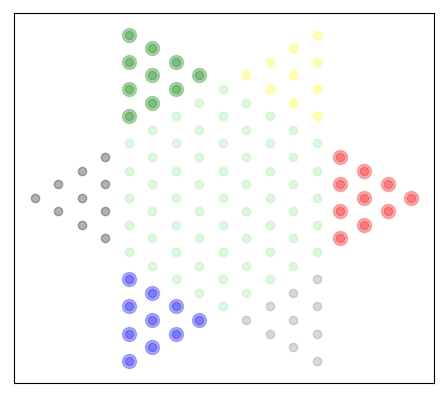

In [16]:
game_plotter = GamePlotter(Game(players=["red", "blue", "green"]), hex_to_rect)
game_plotter.plot()
plt.show()

## Hooks

Hooks are used to intercept the game. `NoHooks` can be used when no game is expected (a plain dictionary works too), and `MultiHooks` can be used to combine many of them. The concrete hooks I've used are `ProgressTrackerHooks` to track each player's progress, and `PlotHooks` to plot each step.

In [17]:
# %load hooks.py
class GameHooks(object):
    def get(self, callback_name, default=None):
        if hasattr(self, callback_name):
            return lambda *args, **kwargs: getattr(self, callback_name)(*args, **kwargs)
        else:
            return default


class NoHooks(GameHooks):
    def get(self, callback, default=None):
        return default


class MultiHooks(GameHooks):
    def __init__(self, *hooks):
        self.hooks = list(hooks)
    
    def add(self, hook):
        self.hooks.append(hook)
    
    def get(self, callback_name, default=None):
        hooks_with_callback = [hook for hook in self.hooks if hasattr(hook, callback_name)]
        if not hooks_with_callback:
            return default
        
        def callback(*args, **kwargs):
            for hook in hooks_with_callback:
                getattr(hook, callback_name)(*args, **kwargs)
        return callback


class ProgressTrackerHooks(GameHooks):
    def __init__(self):
        self.progress = []
        self.progress_for_this_game = defaultdict(list)
    
    def before_game(self, game):
        self.progress_for_this_game = defaultdict(list)
    
    def after_play(self, color, player, moves):
        self.progress_for_this_game[color].append(player.total_progress())
    
    def after_game(self):
        self.progress.append(self.progress_for_this_game)


class PlotHooks(GameHooks):
    def __init__(self,
                 transform=np.array([
                    [    1,            0 ],
                    [ -1/2, np.sqrt(3)/2 ],
                    [  1/2, np.sqrt(3)/2 ],
                 ]),
                 fig_format="hexgrid-figures/tree-{}.png",
                 save_fig=False):
        self.transform = transform
        self.save_fig = save_fig
        self.fig_format = fig_format

    def before_game(self, game):
        mpl.style.use("default")
        self.play_counter = 0
        
        self.plotter = GamePlotter(
            game,
            transformer=CoordinateTransformer(
                transform=np.array(self.transform)
            )
        )
        
        self.plotter.plot(text=True)
        self.xlim = plt.xlim()
        self.ylim = plt.ylim()
    
    def after_move(self, start, end):
        self.plotter.plot_move(start, end)

    def before_play(self, color, player):
        self.plotter.plot()
        
    def after_play(self, color, player, moves):
        self.play_counter += 1
        plt.xticks([])
        plt.yticks([])
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        
        if self.save_fig:
            plt.savefig(self.fig_format.format(self.play_counter))
            plt.close()
        else:
            plt.show()

## Players

The behaviour of a Player is defined by its `play()` method. When called, it returns the player's sequence of moves.

All players know:
* their color
* which game they are playing
* their parameters

`BasePlayer` handles the basic functionality.

### Finding legal moves

The `DepthFirstMoveFinderMixin` class can be mixed in to find every available move by calling the player's `moves()` method. The resulting generator will perform a depth-first search through every possible sequence of legal moves with a legal end-position, and return them one by one.

For each play, there will often exist more "efficient" sequences which are equivalent to it, but which involve fewer moves. There is no reason to search for the the most "efficient" solution in this case, except maybe to show how a human would perform the sequence.

Adding this class makes the player remember the previous few positions it has been in (through `self.explored_positions`). It uses this memory to avoid returning to a previous position, which could end up with us getting stuck in the endgame.

### Progress maximizing player

A player generally wants to maximize some measure of progress (i.e. how far across the board the pieces have moved). The `BaseProgressTracker` class has the logic needed to choose the optimal move based on the progress for each move. Subclasses must define a `moves()` function which returns the possible moves and a measure of progress for each move. 

The default method of choosing a move is as follows: if there is a single move that yields higher progress than all the others, take that move. If several moves share the first place, then choose randomly between them. This also helps preventing the player from getting stuck during the end-game.

The `NonPlanningProgressMaximizer` is a concrete player which inherits from both `DepthFirstMoveFinderMixin` and `BaseProgressTracker` (it actually does nothing else). It makes super-clever moves, but it doesn't plan ahead. Therefore, it often ends up with a piece or two that's way behind.

### Dumb players

The `RandomSingleMovePlayer` plays a single randomly picked legal move each round. In a sense, the pieces act as gas molecules moving randomly on a hexagonal grid, with very weird nonlocal interactions between molecules. `RandomPlayer` plays a randomly picked legal sequence of moves each round, making the physics even weirder. 
The `SingleMoveProgressMaximizer` plays the best single jump.

These players are all pretty dumb - they were the first players I implemented, and they are helpful reference implementations of simple concrete players. They also run super fast. They have some use as models for planning players - ideally you would want to predict your opponent's moves and act on the predictions, but maybe you can get a long way by assuming they move randomly and looking at the expected future progress for each move?

### Planning

`PlanningProgressMaximizer` is my current attempt at a player that plans ahead. It doesn't work yet. It can use any other player to model its opponents (though using another `PlanningProgressMaximizer` would probably lead to some infinitely recursing problems). 

### Learning

The next step after getting the players to plan, is to get them to learn. Some sort of reinforcement learning algorithm seems appropriate.

In [18]:
# %load players.py
from collections import deque
import random
import networkx as nx

class Player(object):
    """Basic player with no defined behavious"""
    def __init__(self, name, game, params=None):
        self.name = name
        self.game = game
        self.params = params
    
    def __repr__(self):
        return "Player(name={}, class={}, {})".format(self.name, type(self).__name__, ", ".join("{}={}".format(key, value) for key, value in self.params.items()))
        
    def __str__(self):
        return repr(self)
        
    def total_progress(self):
        board = self.game.board
        spots = self.game.player_spots[self.name]
        return sum(board.progress_function[self.name](spot) for spot in spots)

    def positions(self):
        return self.game.player_spots[self.name]


class DepthFirstMoveFinderMixin(Player):
    """Explores the entire tree of possibilities"""
    def __init__(self, name, game, params):
        super().__init__(name, game, params)
        self.explored_positions = deque([], maxlen=params.get('position_memory', 5))
    
    def moves(self):
        game = self.game
        board = self.game.board
        
        self.explored_positions.append(frozenset(self.positions()))
        
        for i in range(game.pieces_per_player):
            start_spot = game.player_spots[self.name][i]
            progress_before = board.progress_function[self.name](start_spot)
            
            move_tree = nx.DiGraph()
            move_tree.add_node(start_spot)
            
            self.explore(start_spot, move_tree, MoveState.FIRST, 1)
            for endpoint in move_tree.nodes():
                if endpoint != start_spot and game.is_legal_endpoint(self.name, start_spot, endpoint):
                    progress = board.progress_function[self.name](endpoint) - progress_before
                    path = list(self.path(start_spot, endpoint, move_tree))
                    yield progress, path

    def explore(self, start_spot, move_tree, move_state, depth):
        # Iterate over every legal move
        for move, next_move_state in self.game.get_legal_moves(self.name, start_spot, move_state):
            # Don't go in circles
            if move in move_tree.nodes:
                continue
            
            # Try the move
            self.game.push_move(self.name, start_spot, move, move_state)
            
            # See if we have seen this set of positions before.
            # If so, don't do the same thing again.
            position = frozenset(self.positions())
            if position in self.explored_positions:
                self.game.pop_move()
                continue
            
            # OK, this is new. Add the move to the tree
            move_tree.add_node(move)
            move_tree.add_edge(start_spot, move)
            
            # If we are at max depth, do not explore further
            if depth >= self.params['max_depth']:
                self.game.pop_move()
                continue
            
            # Go deeper
            self.explore(move, move_tree, next_move_state, depth + 1)
            self.game.pop_move()
    
    def path(self, start_spot, endpoint, move_tree):
        for path in nx.algorithms.simple_paths.all_simple_paths(move_tree, start_spot, endpoint):
            return path

class BaseProgressTracker(Player):
    def play(self):
        return self.choose(self.build_heap())
    
    def build_heap(self):
        heap = []
        for progress, move in self.moves():
            heapq.heappush(heap, (-progress, move))
        return heap

    def choose(self, heap):
        minus_max_progress, move = heapq.heappop(heap)
        max_pool = [move]
        max_pool_exhausted = False
        while not max_pool_exhausted:
            try:
                minus_progress, move = heapq.heappop(heap)
            except IndexError:
                break
            minus_progress = round(minus_progress, 2)
            if minus_progress != minus_max_progress:
                break
            max_pool.append(move)
        return random.choice(max_pool)

class NonPlanningProgressMaximizer(BaseProgressTracker, DepthFirstMoveFinderMixin):
    """Look ma, no code"""


class RandomSingleMovePlayer(Player):
    def play(self):
        game = player.game
        start_spot = game.player_spots[player.name][np.random.choice(game.pieces_per_player)]
        legal_moves = game.get_legal_moves(player.name, start_spot)
        while True:
            endpoint, move_state = random.choice(legal_moves)
            if game.is_legal_endpoint(player.name, start_spot, endpoint):
                return [start_spot, endpoint]


class RandomPlayer(DepthFirstMoveFinderMixin):
    def play(self):
        return random.choice([move] for _, move in self.moves())


class SingleMoveProgressMaximizer(BaseProgressTracker):
    """Picks a sequence consisting of the single move that increases the score the most"""
    def moves(self):
        for i in range(self.game.pieces_per_player):
            yield from self.moves_for_piece(self.game.player_spots[self.name][i])

    def moves_for_piece(self, start_spot):
        game = self.game
        board = self.game.board
        progress_before = board.progress_function[self.name](start_spot)
        legal_moves = game.get_legal_moves(self.name, start_spot)
        for move, move_state in legal_moves:
            if game.is_legal_endpoint(self.name, start_spot, move):
                progress = board.progress_function[self.name](move) - progress_before
                yield progress, [start_spot, move]

class PlanningProgressMaximizer(BaseProgressTracker):
    def __init__(self, name, game, params):
        super().__init__(name, game, params)
        self.move_finder = NonPlanningProgressMaximizer(name, game, { 'max_depth': params['max_depth'] })
        self.opponent_models = params.get('opponent_models', [])

    def pop_n(self, n):
        for i in range(n):
            self.game.pop_move()
        
    def explore_consequences(self, depth, explored_positions, move=None):
        if depth == self.params['max_play_depth']:
            yield self.total_progress(), move
            return

        # Get the heap of moves
        heap = self.move_finder.build_heap()
        for i in range(min(self.params['fanout'], len(heap))):
            n_pushes = 0
            m_progress, play = heapq.heappop(heap)
            
            # At depth=0, we consider every move. At depth > 0, we only consider the top-level move
            if depth == 0:
                move = play
            
            # Only need to consider the start and end point
            start = play[0]
            end = play[-1]
            
            # Fake-play the move
            self.game.push_move(self.name, start, end, MoveState.ALREADY_CHECKED)
            n_pushes += 1
            
            # If this position has been explored already, don't explore further
            position = frozenset(self.positions())
            if position in explored_positions:
                self.pop_n(n_pushes)
                break
            explored_positions.add(position)
            
            # Let the opponents move
            for opponent in self.opponent_models:
                opponent_move = opponent.play()
                opponent_start = opponent_move[0]
                opponent_end = opponent_move[-1]
                self.game.push_move(self.name, start, end, MoveState.ALREADY_CHECKED)
                n_pushes += 1
            
            # Check the expected total progress after doing the move
            sum_progress = 0
            n_moves = 0
            for total_progress, _move in self.explore_consequences(depth + 1, explored_positions, move):
                sum_progress += total_progress
                n_moves += 1
            
            # If there were no possible moves, just continue
            if n_moves == 0:
                self.pop_n(n_pushes)
                continue
            
            # Yield the mean progress for the move
            yield sum_progress / n_moves, move
            self.pop_n(n_pushes)
    
    def moves(self):
        explored_positions = set()
        explored_positions.add(frozenset(self.positions()))
        for total_progress, move in self.explore_consequences(0, explored_positions):
            yield total_progress, move

## Simulator

A `Simulator` can run many games and look at the behaviour over time.

A `ResultsPlotter` plots the result of a simulation.

In [19]:
# %load simulator.py
from itertools import combinations

def populate_opponent_models(game, players, model_classes, model_params):
    m = len(players)
    
    assert m == len(model_classes), "{} players and {} model classes".format(m, len(model_classes))
    assert m == len(model_params), "{} players and {} model param dicts".format(m, len(model_params))
    
    for i in range(m):
        if not hasattr(players[i], 'opponent_models'):
            continue
        assert len(players[i].opponent_models) == 0
        
        for j in range(1, m):
            k = (i + j) % m
            model = model_classes[k](players[k].name, game, model_params[k])
            players[i].opponent_models.append(model)

class Simulator(object):
    def __init__(
        self,
        player_class,
        player_params=None,
        max_steps=50,
        n=4,
        hooks=None,
        player_colors = ("red","black",),
        opponent_classes=None,
        opponent_params=None,
    ):
        self.n = n
        self.hooks = hooks if hooks else NoHooks()
        self.player_colors = player_colors
        self.player_class = player_class
        self.player_params = player_params
        self.max_steps = max_steps
        self.winners = []
        
        if opponent_classes:
            self.opponent_classes = opponent_classes
        else:
            self.opponent_classes = []
        
        if opponent_params:
            self.opponent_params = opponent_params
        else:
            self.opponent_params =  [{} for opponent_class in self.opponent_classes]
    
    def execute(self, n_sims):
        for run in range(n_sims):
            game = Game(self.player_colors, self.n)
            
            player_list = [
                self.player_class(color, game, self.player_params)
                for color in self.player_colors
            ]
            player_dict={
                player.name: player
                for player in player_list
            }
            if self.opponent_classes:
                populate_opponent_models(game, player_list, self.opponent_classes, self.opponent_params)
            winners_this_run = game.run(
                max_steps=self.max_steps,
                players=player_dict,
                hooks=self.hooks
            )
            self.winners.append(winners_this_run)

class ResultPlotter(object):
    def __init__(self, simulator):
        self.simulator = simulator
    
    def get_dists(self):
        return {
            color: [
                steps
                for step_winners
                in simulator.winners
                for color_, steps
                in step_winners
                if color_ == color
            ]
            for color in self.simulator.player_colors
        }
    
    def plot_distributions(self):
        plt.figure(figsize=(7, 7))
        dists = self.get_dists()
        for color, dist in dists.items():
            plt.hist(
                dist, 
                alpha=0.8,
                color=color,
                bins=15
            )
        plt.xlabel("Number of moves")
        plt.ylabel("Density")
        plt.title("Distribution of game lengths")
        plt.show()
    
    def plot_correlations(self):
        dists = self.get_dists()
        for color_x, color_y in combinations(self.simulator.player_colors, 2):
            plt.figure(figsize=(7, 7))
            dist_x = dists[color_x]
            dist_y = dists[color_y]
            min_ = min(*dist_x, *dist_y)
            max_ = max(*dist_x, *dist_y)
            ties = [(x, y) for x, y in zip(dist_x, dist_y) if x == y]
            dist_x, dist_y = [x for x, y in zip(dist_x, dist_y) if x != y], [y for x, y in zip(dist_x, dist_y) if x != y]
            colors = [color_x if x < y else color_y for x, y in zip(dist_x, dist_y)]

            plt.scatter(dist_x, dist_y, alpha=0.5, color=colors)
            if ties:
                plt.scatter(*zip(*ties), marker="x")
            plt.xlabel("#moves by {}".format(color_x))
            plt.ylabel("#moves by {}".format(color_y))
            plt.xlim(min_ - 1, max_ + 1)
            plt.ylim(min_ - 1, max_ + 1)
            plt.title("Matchup: {} vs. {}".format(color_x, color_y))
            plt.axis("equal")
            plt.show()

## Running some games

Let's finally run a game, plotting each step and saving the progress each time. There should be some pretty wild moves here.

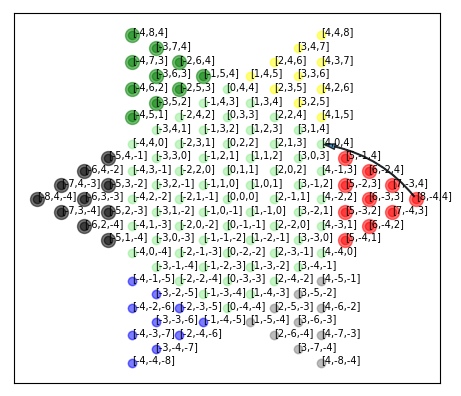

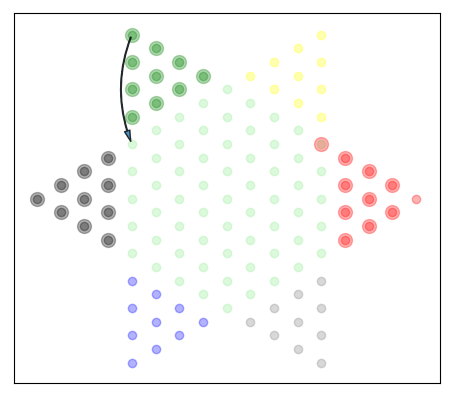

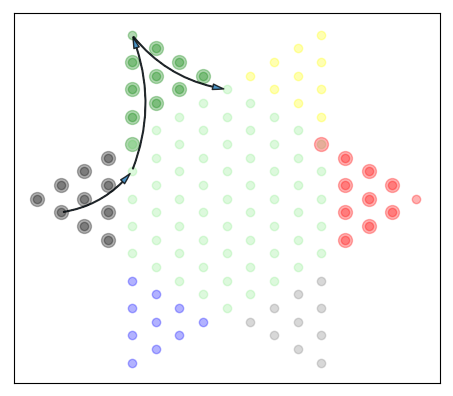

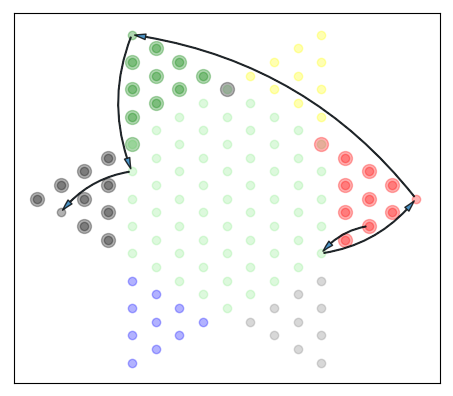

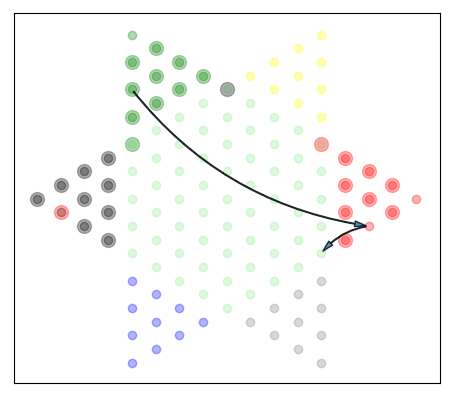

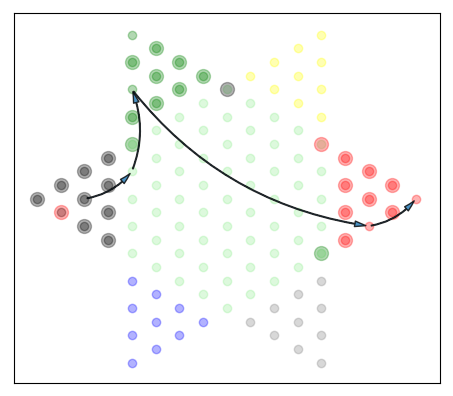

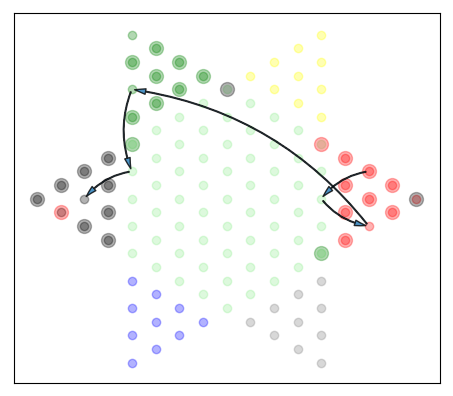

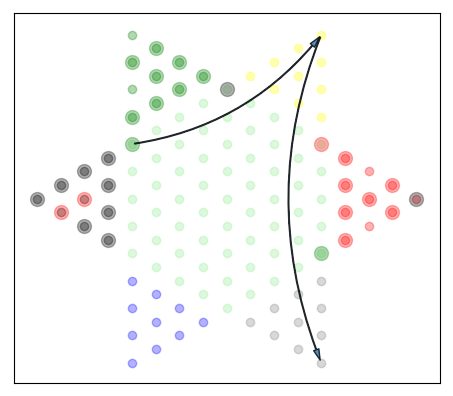

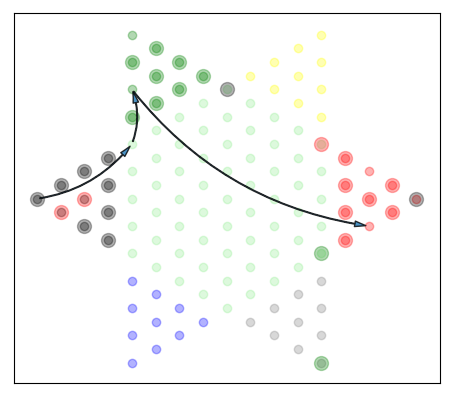

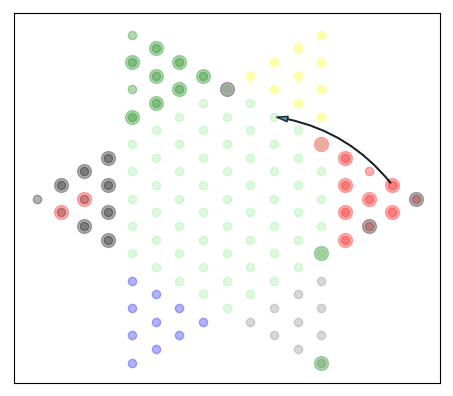

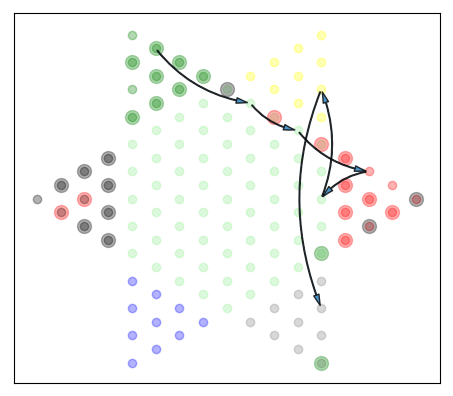

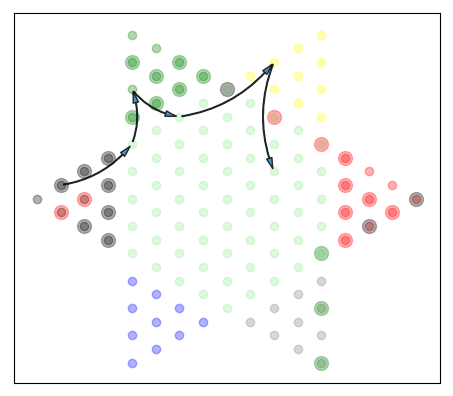

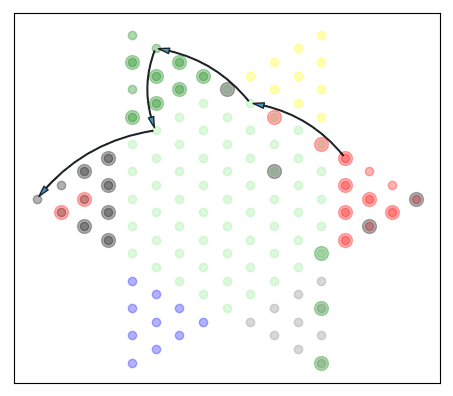

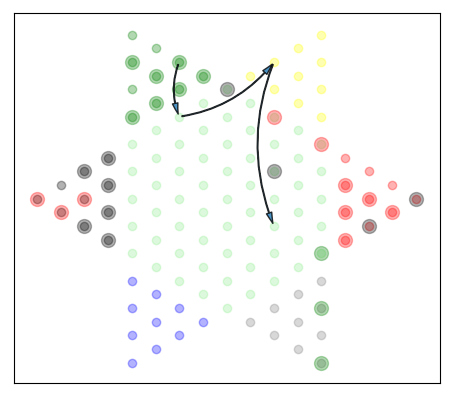

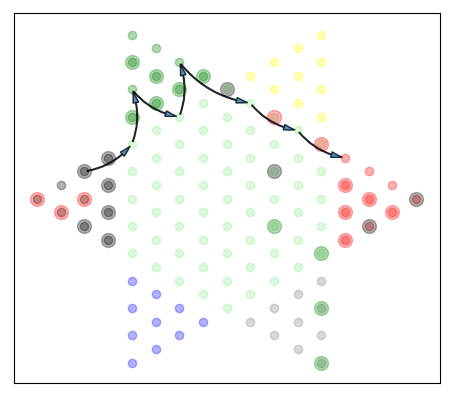

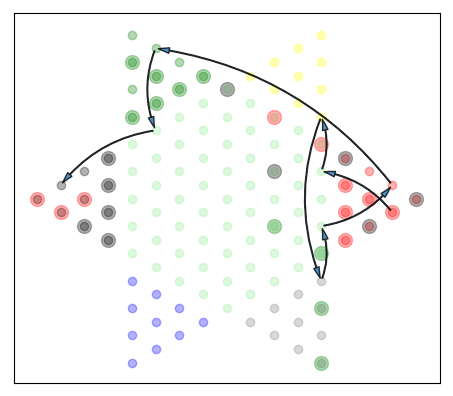

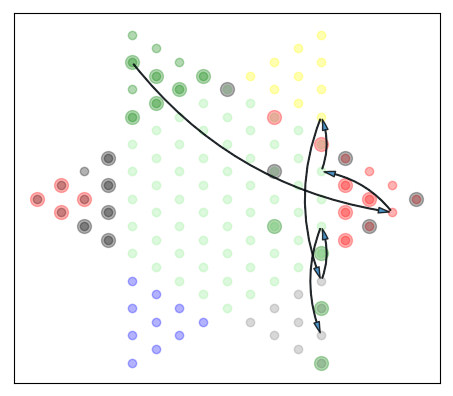

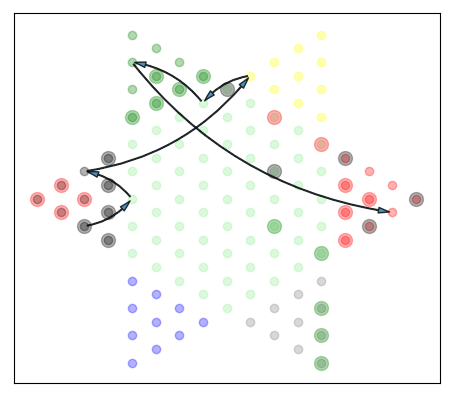

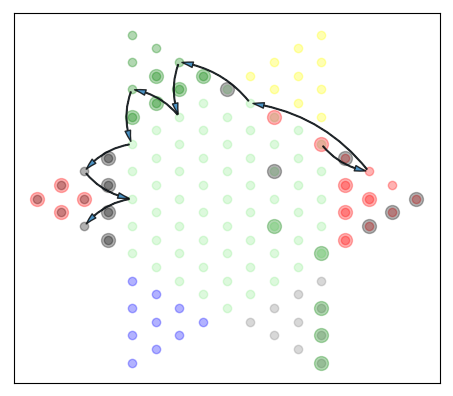

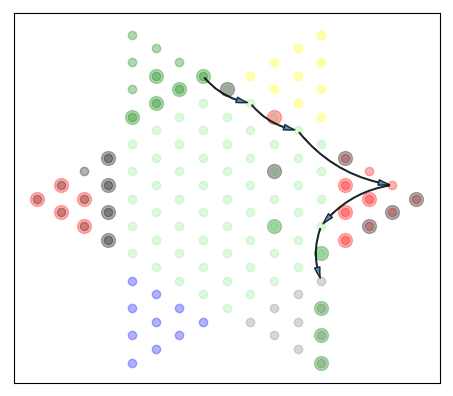

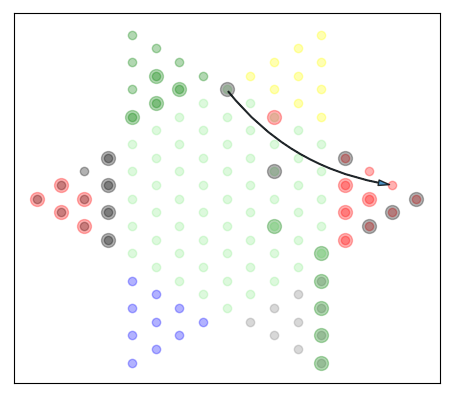

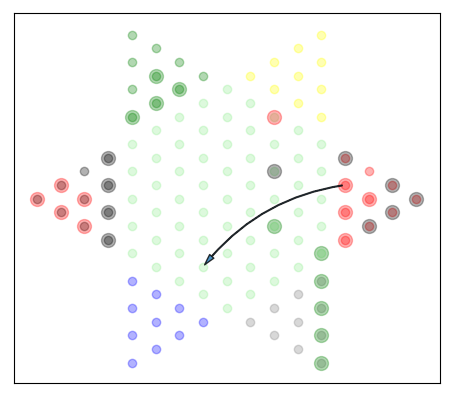

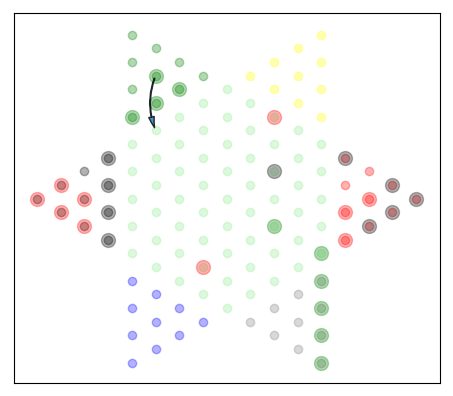

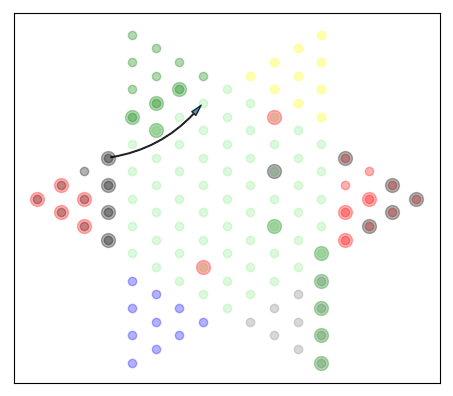

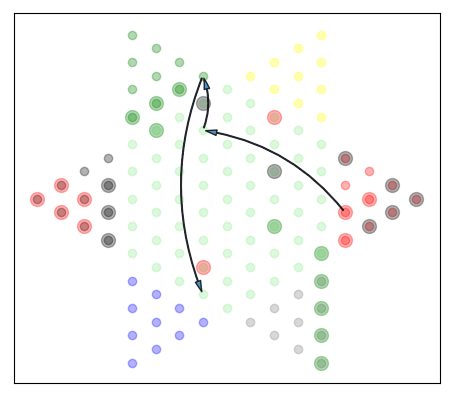

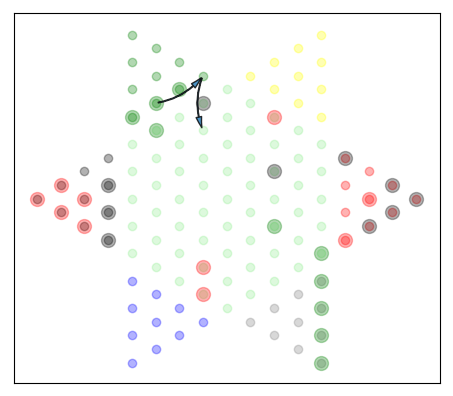

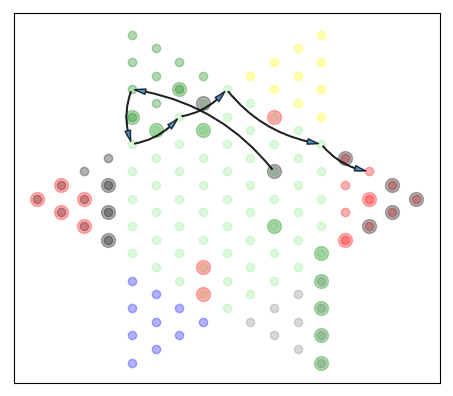

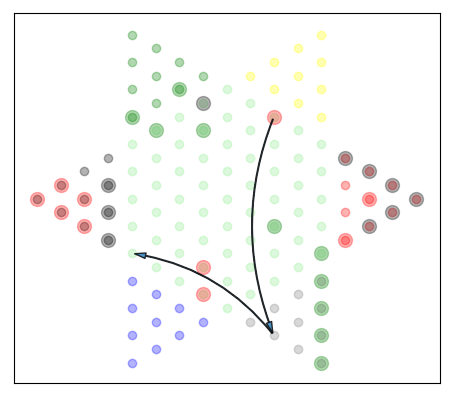

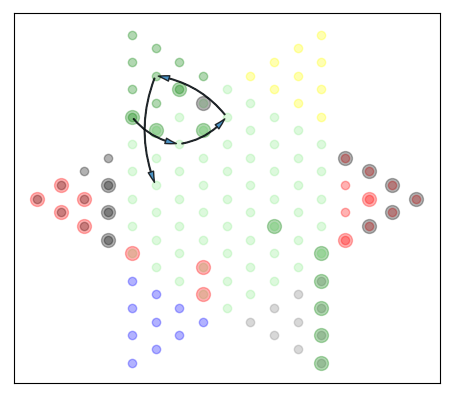

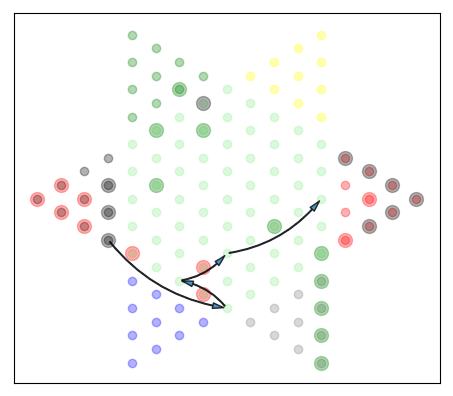

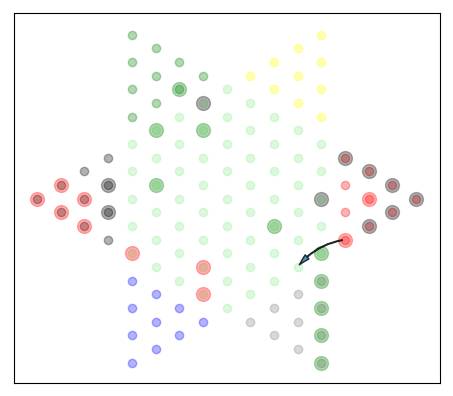

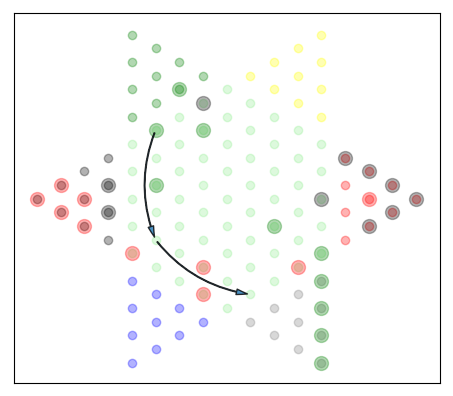

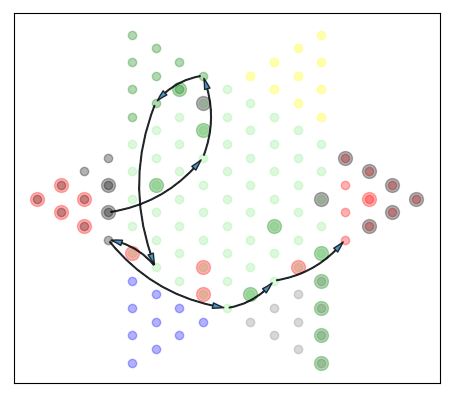

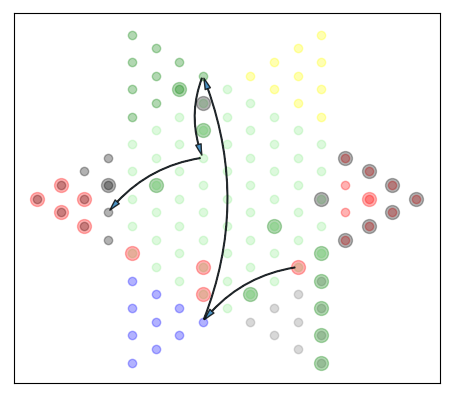

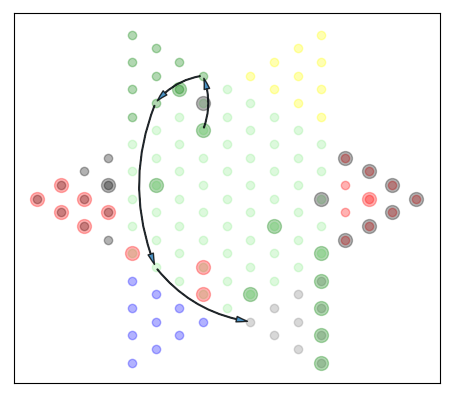

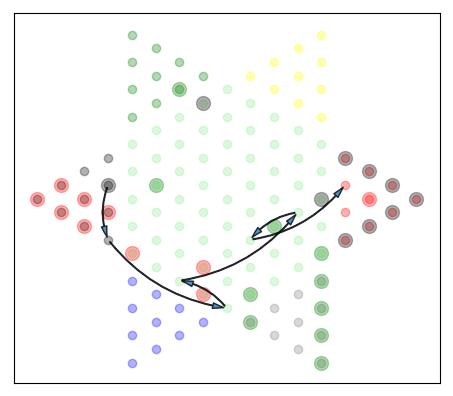

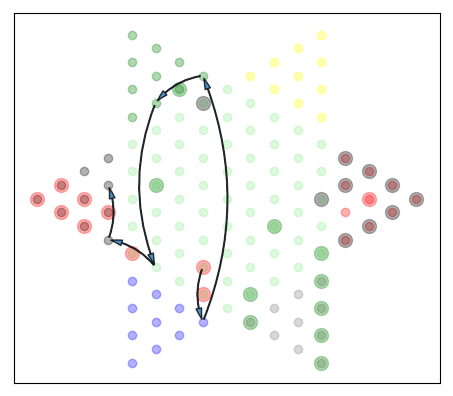

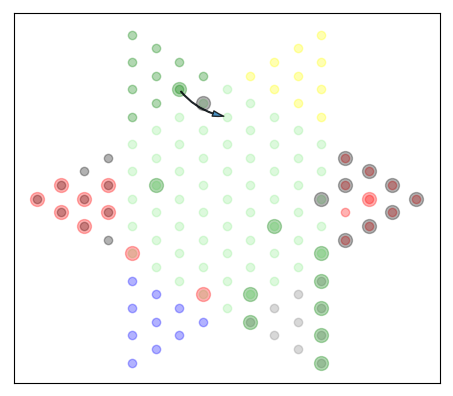

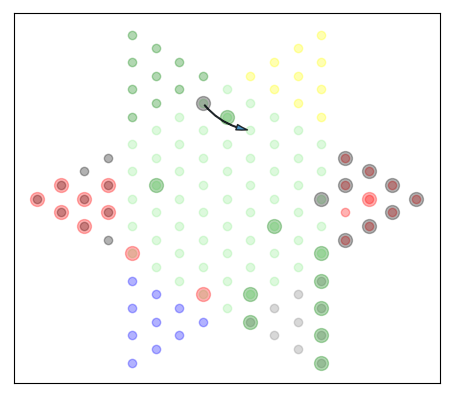

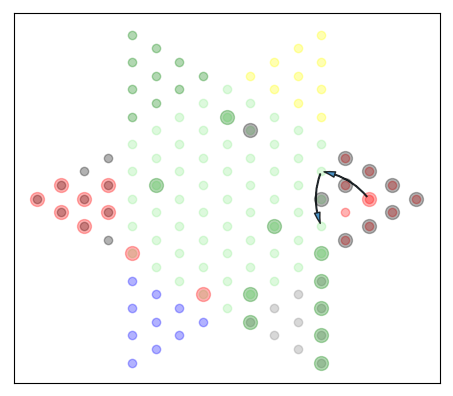

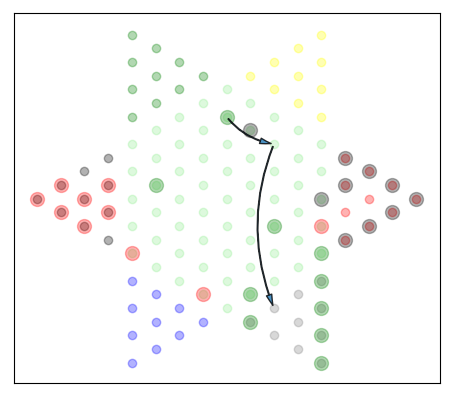

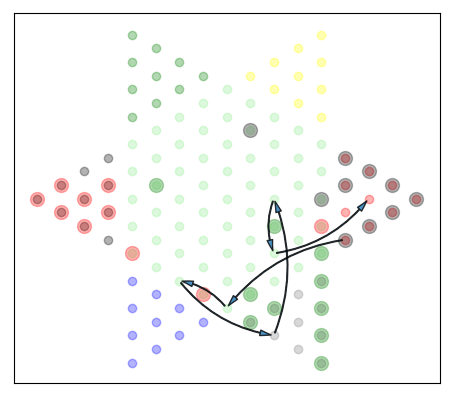

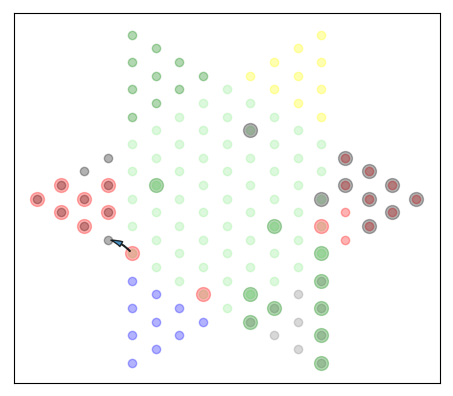

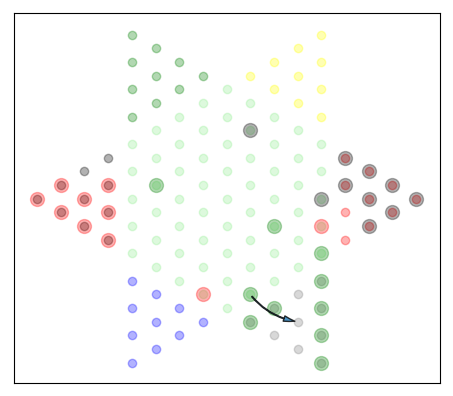

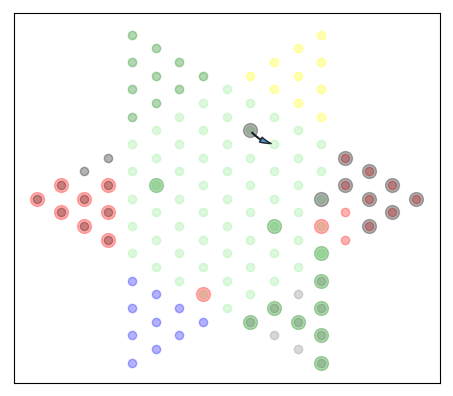

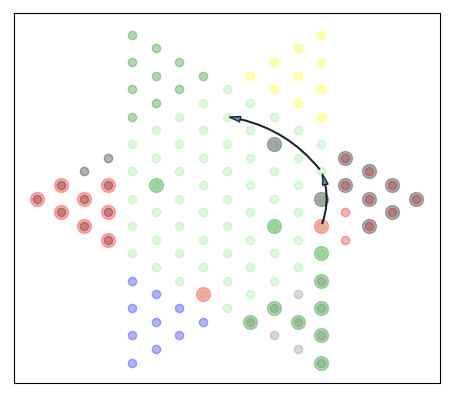

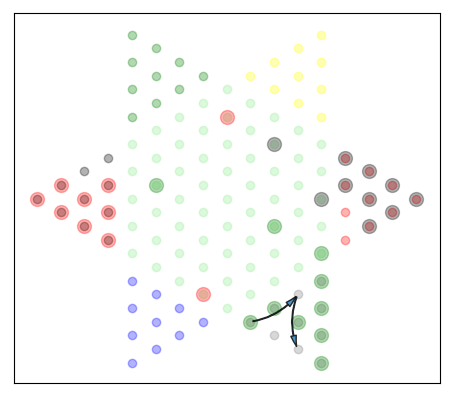

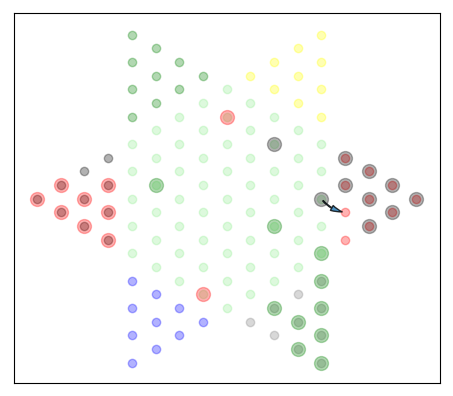

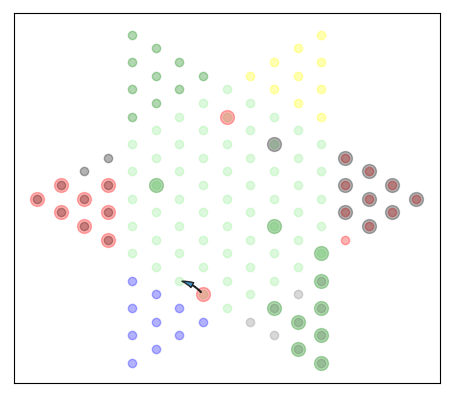

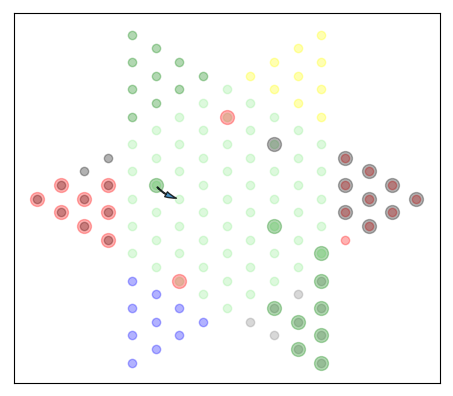

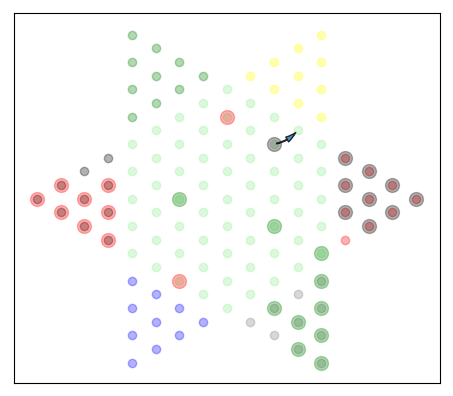

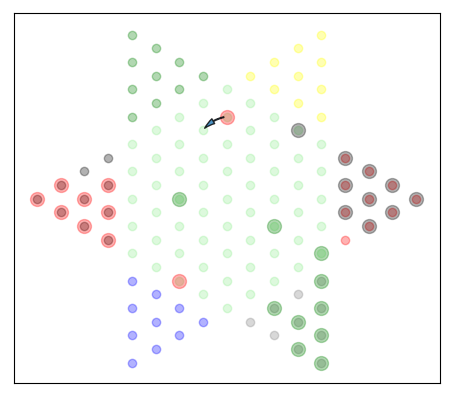

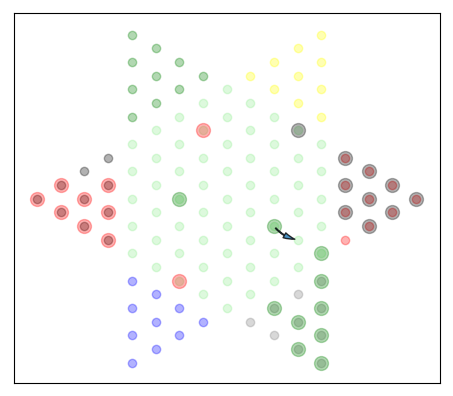

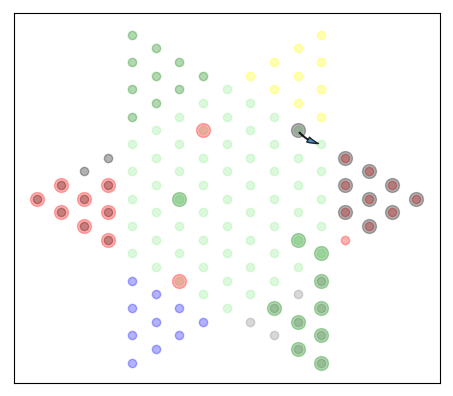

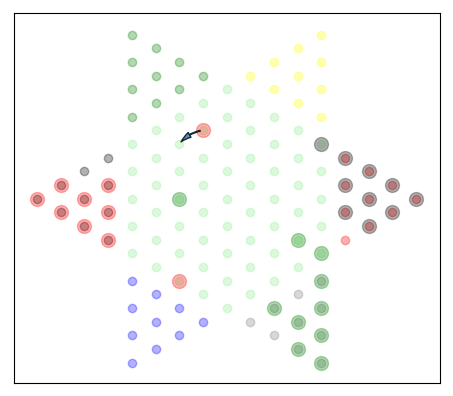

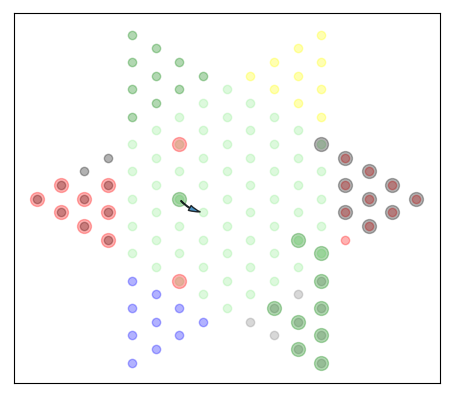

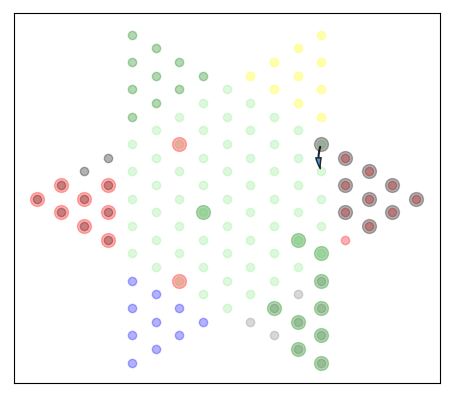

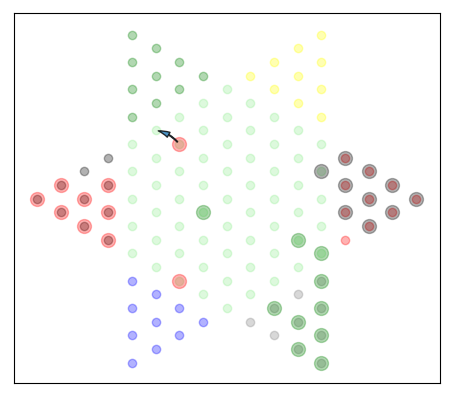

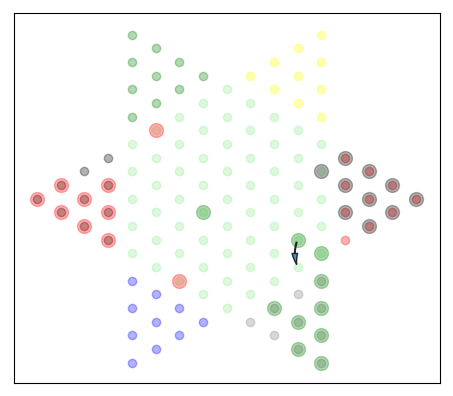

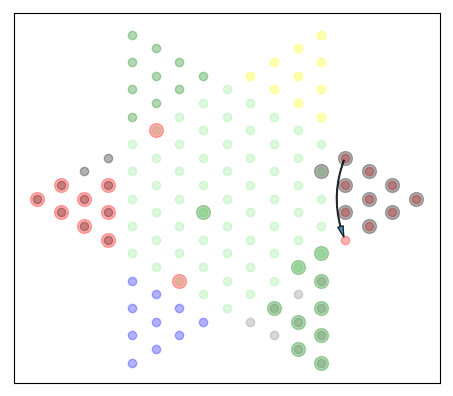

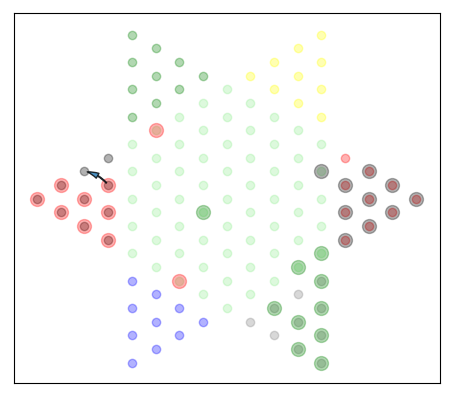

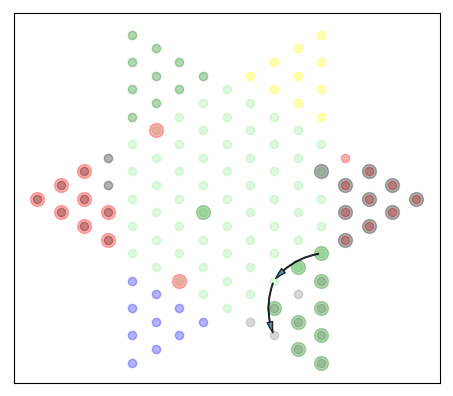

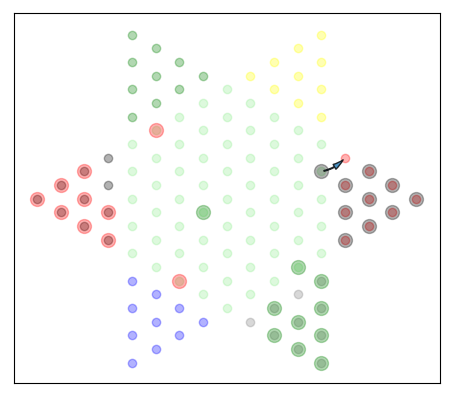

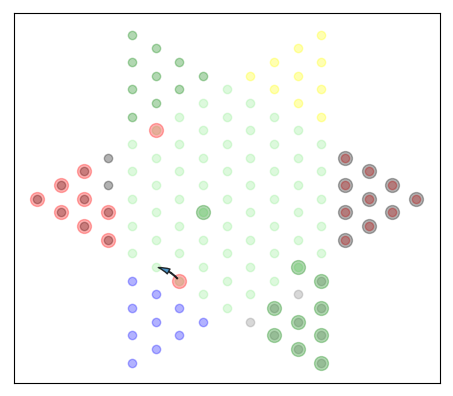

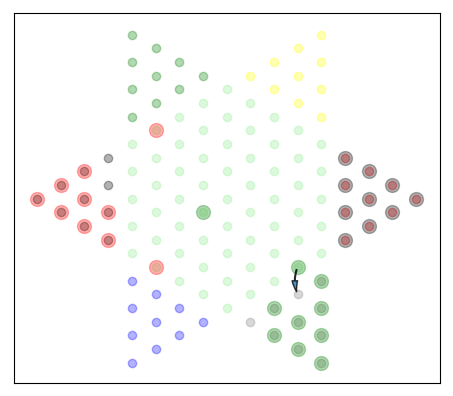

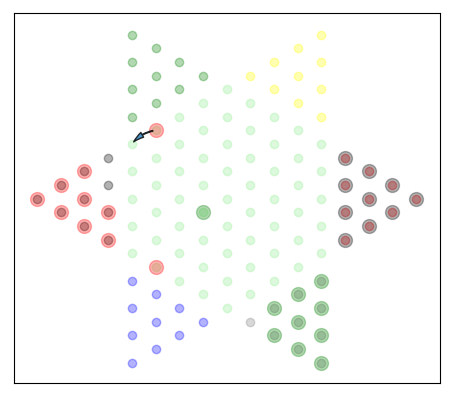

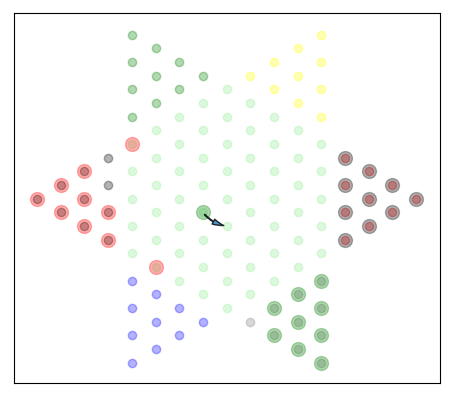

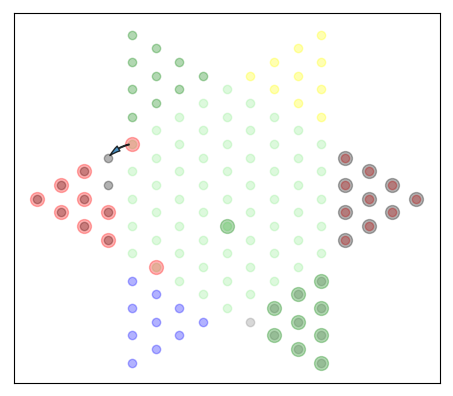

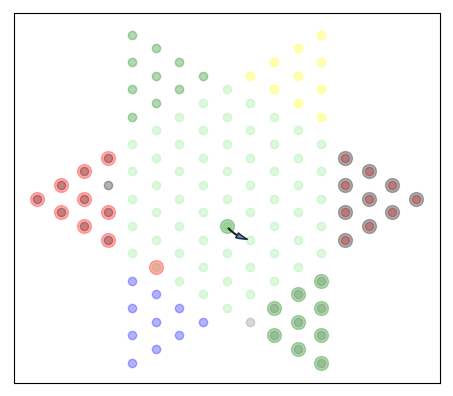

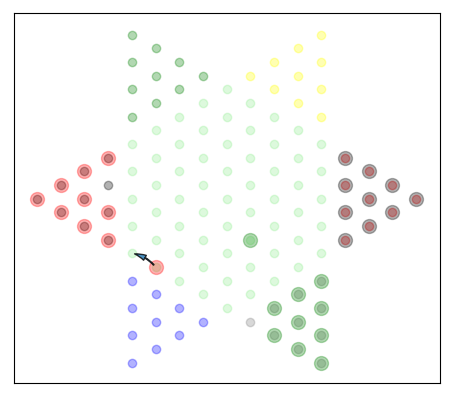

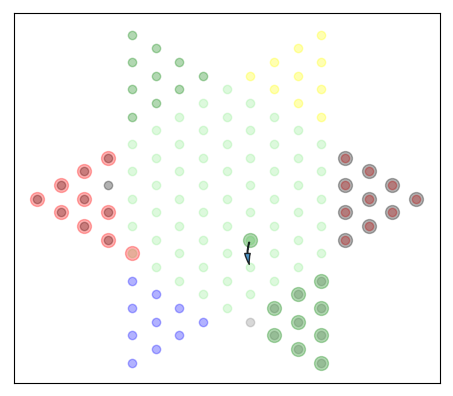

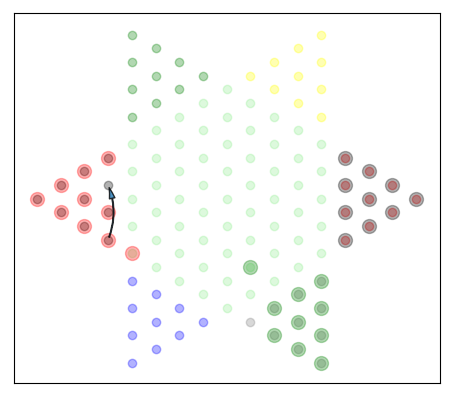

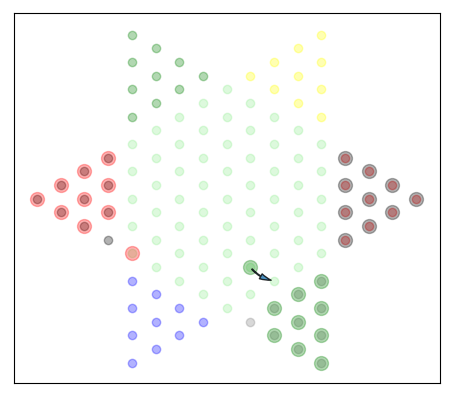

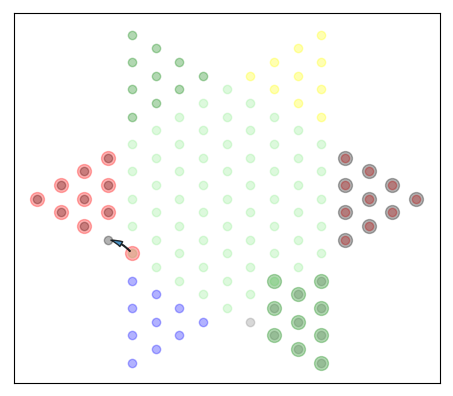

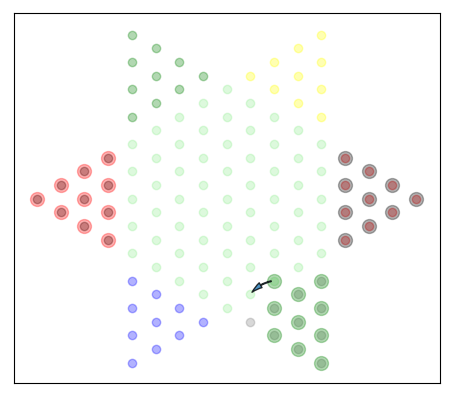

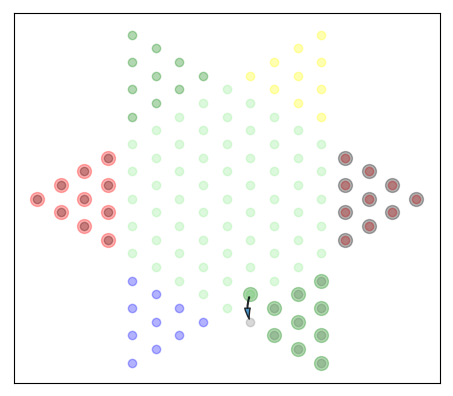

In [20]:
hooks = MultiHooks()
hooks.add(ProgressTrackerHooks())
hooks.add(PlotHooks())

player_colors = ("red", "green", "black")
    
simulator = Simulator(
    max_steps=100,
    n=4,
    player_class=NonPlanningProgressMaximizer,
    hooks=hooks,
    player_colors=player_colors,
    player_params={ 'max_depth': 10, 'fanout': 2, 'max_play_depth': 2 },
    #opponent_classes = [RandomPlayer for _ in range(len(player_colors))],
    #opponent_params = [{'max_depth': 3} for _ in range(len(player_colors))]
)
simulator.execute(1)

### Progress over time

Using the data from the progress tracker to look at the progress over time. There is usually relatively small progress for the first few moves, then massive progress until about halfway where only a couple of pieces are left. Progress then remains extremely slow until the endame.

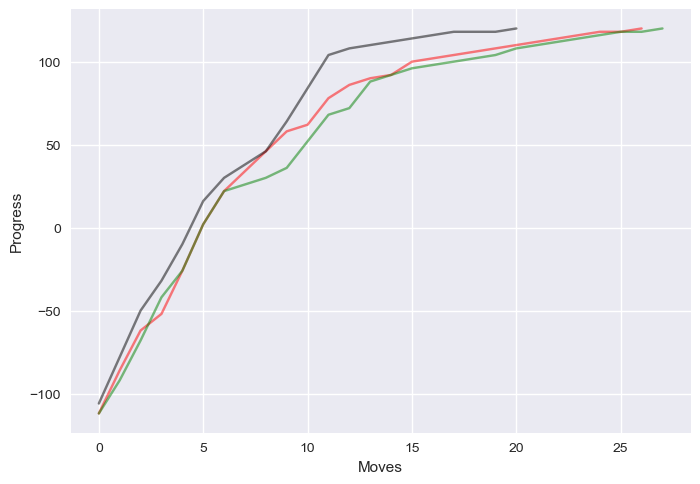

In [21]:
plots.progress_time_plot(hooks.hooks[0].progress)

### Running many games

Let's run the simulation for a while and see how the results look over many runs.

In [22]:
simulator.hooks = ProgressTrackerHooks()

In [36]:
# To get more data, run this cell many times
simulator.execute(100)

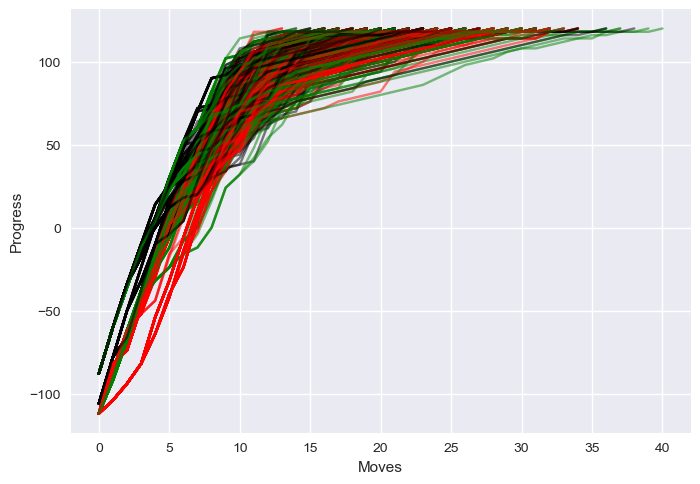

In [37]:
plots.progress_time_plot(simulator.hooks.progress)

### Distribution of game lengths

The plot below shows the distribution of game lengths for each player.

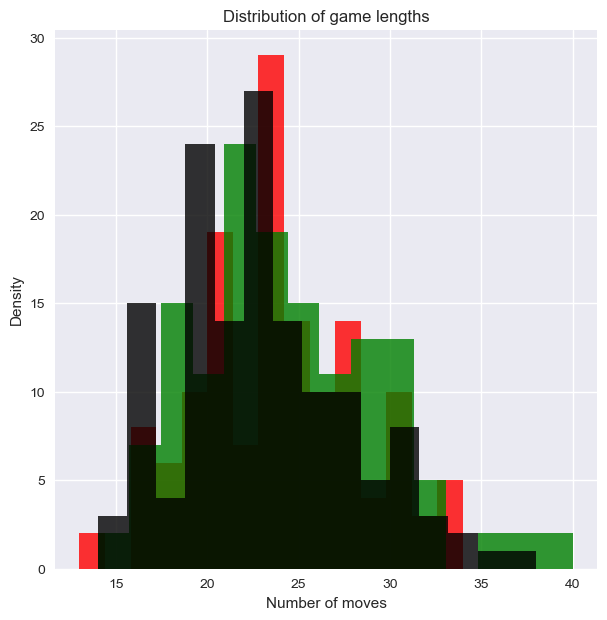

In [38]:
rpl = ResultPlotter(simulator)
rpl.plot_distributions()

Each game is represented by one point in the scatter plots below.

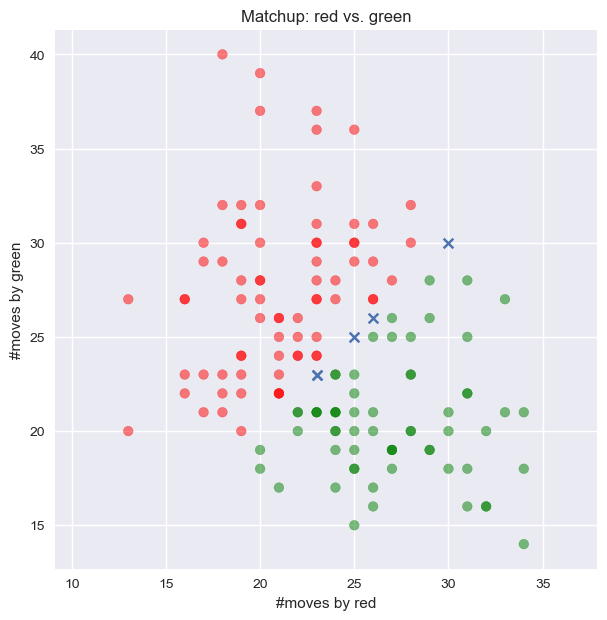

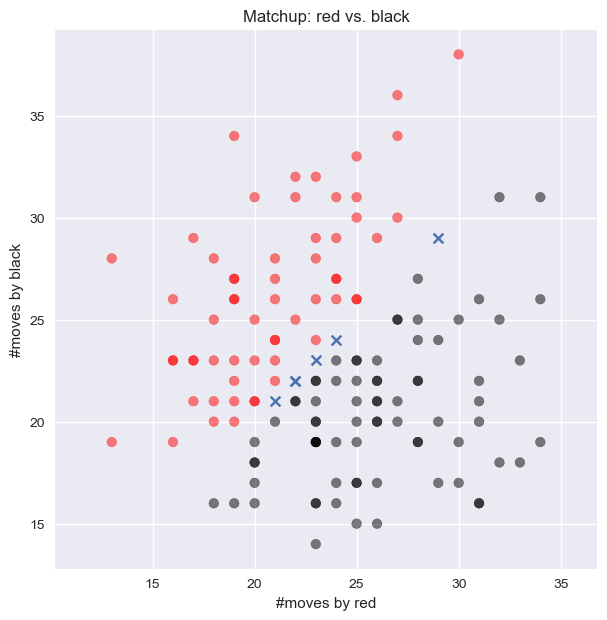

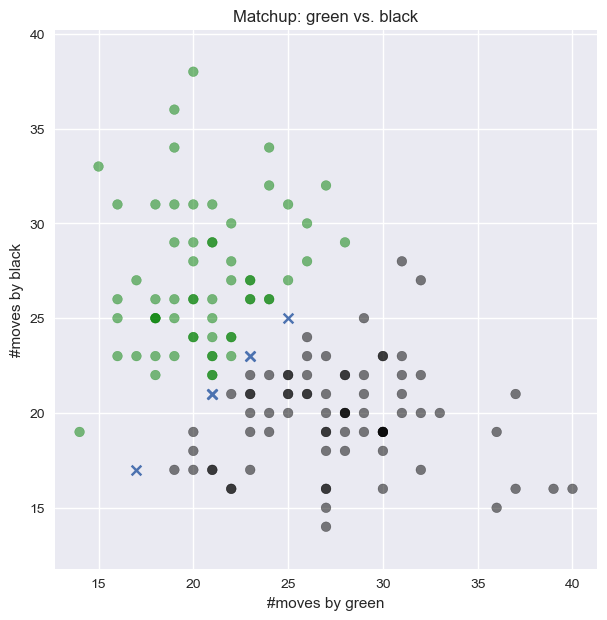

In [39]:
rpl.plot_correlations()